In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir(r'/content/drive/My Drive/torchray_master')  # Change the directory to torchRay-master folder

# Requirements

In [3]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2

In [4]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [5]:
from mnist1d_utils import *

# Dataset

In [6]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

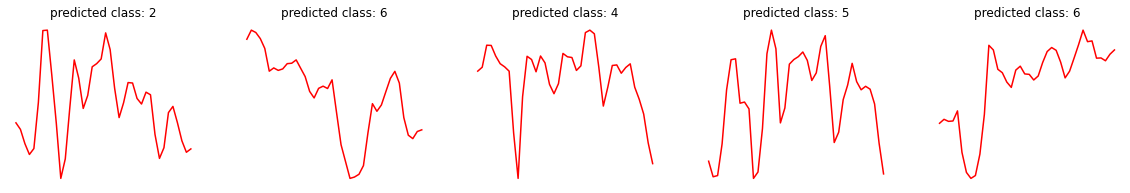

In [7]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

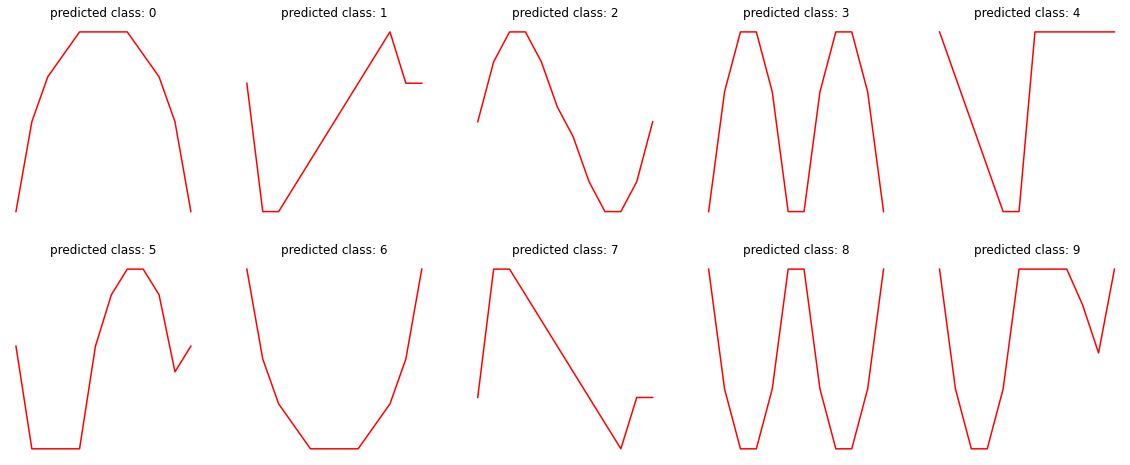

In [8]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [9]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [10]:
##Task1-Question1
weight_decay = 5e-4
Nfeatures = dataset['x'].shape[1] 
Nclasses = len(np.unique(dataset['y']))
model = Sequential()
model.add(Conv1D(25, kernel_size=5, strides=1, padding='same', activation='relu',kernel_initializer='he_normal', input_shape=(Nfeatures, 1), kernel_regularizer=regularizers.l2(weight_decay) ))
model.add(Conv1D(25, kernel_size=3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal',kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, kernel_size=3, strides=1, padding='same', activation='relu',kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(Nclasses, activation='softmax', kernel_initializer=keras.initializers.RandomNormal(mean=0.0, stddev=0.5),
                bias_initializer=keras.initializers.Zeros(), kernel_regularizer=regularizers.l2(weight_decay)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 40, 25)            150       
                                                                 
 conv1d_1 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 conv1d_2 (Conv1D)           (None, 40, 25)            1900      
                                                                 
 flatten (Flatten)           (None, 1000)              0         
                                                                 
 dense (Dense)               (None, 10)                10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [11]:
##Task1-Question2
%load_ext tensorboard
from datetime import datetime
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir)

y_train = tensorflow.keras.utils.to_categorical(dataset['y'])
y_testt = tensorflow.keras.utils.to_categorical(dataset['y_test']) 

opt=tensorflow.keras.optimizers.SGD(learning_rate=0.01)
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=['accuracy'])
#history = model.fit(np.expand_dims(dataset['x'], axis=-1), dataset['y'], epochs=200,validation_split=0.1, callbacks=[tensorboard_callback]) #validation_data=(np.expand_dims(dataset['x_test'], axis=-1),y_testt)
history = model.fit(np.expand_dims(dataset['x'], axis=-1), y_train, epochs=200,validation_split=0.1, callbacks=[tensorboard_callback], validation_data=(np.expand_dims(dataset['x_test'], axis=-1), y_testt))
model.save('MNIST1D.h5')

Epoch 1/200
113/113 [==============================] - 3s 15ms/step - loss: 4.1289 - accuracy: 0.1081 - val_loss: 3.6485 - val_accuracy: 0.0900
Epoch 2/200
113/113 [==============================] - 1s 11ms/step - loss: 3.6205 - accuracy: 0.1069 - val_loss: 3.6468 - val_accuracy: 0.1100
Epoch 3/200
113/113 [==============================] - 1s 11ms/step - loss: 3.6058 - accuracy: 0.1350 - val_loss: 3.6411 - val_accuracy: 0.0800
Epoch 4/200
113/113 [==============================] - 1s 10ms/step - loss: 3.5820 - accuracy: 0.1458 - val_loss: 3.6293 - val_accuracy: 0.1100
Epoch 5/200
113/113 [==============================] - 1s 10ms/step - loss: 3.5637 - accuracy: 0.1569 - val_loss: 3.6149 - val_accuracy: 0.1275
Epoch 6/200
113/113 [==============================] - 1s 10ms/step - loss: 3.5477 - accuracy: 0.1683 - val_loss: 3.6048 - val_accuracy: 0.1325
Epoch 7/200
113/113 [==============================] - 1s 9ms/step - loss: 3.5260 - accuracy: 0.1836 - val_loss: 3.5840 - val_accuracy: 

# Plotting the training progress

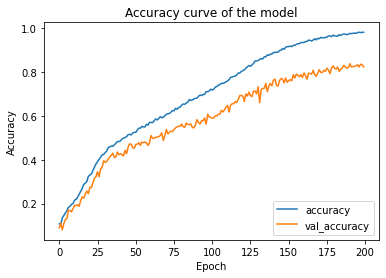

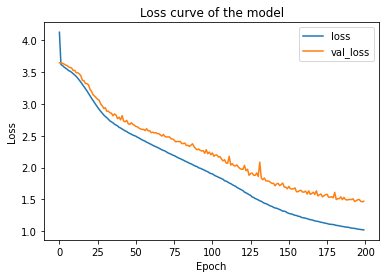

<Figure size 432x288 with 0 Axes>

In [12]:
##Task1-Question3.a
plt.title('Accuracy curve of the model')
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

plt.title('Loss curve of the model')
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()
plt.savefig('/content/drive/My Drive/torchray_master/Accuracy_curve_MNIST1D.png')

In [13]:
##Task1-Question3.b
model=load_model('MNIST1D.h5')
loss, acc=model.evaluate(np.expand_dims(dataset['x_test'], axis=-1), y_testt)

print('Overall classification accuracy: %.3f' % (acc * 100.0))
predicted=model.predict([np.expand_dims(dataset['x_test'], axis=-1)])
predicted_class=np.argmax(predicted, axis=1)

32/32 [==============================] - 0s 3ms/step - loss: 1.3410 - accuracy: 0.8680
Overall classification accuracy: 86.800


In [14]:
##Task1-Question3.c
predicted_class_=tensorflow.keras.utils.to_categorical(predicted_class) 

# we know that recall for say class positive is (TP/(TP+FN)) or TP/P this is called sensitivity, recall, class accuracy or the class recognition rate 
for i in range(10): 
  print("The accuracy of class "+str(i)+" is: "+str(round(metrics.classification_report(y_testt,predicted_class_,output_dict=True)[str(i)]['recall'],4)))


The accuracy of class 0 is: 0.9608
The accuracy of class 1 is: 0.8173
The accuracy of class 2 is: 0.8427
The accuracy of class 3 is: 0.9717
The accuracy of class 4 is: 0.8019
The accuracy of class 5 is: 0.8571
The accuracy of class 6 is: 0.9192
The accuracy of class 7 is: 0.9167
The accuracy of class 8 is: 0.9082
The accuracy of class 9 is: 0.6863


<Figure size 432x288 with 0 Axes>

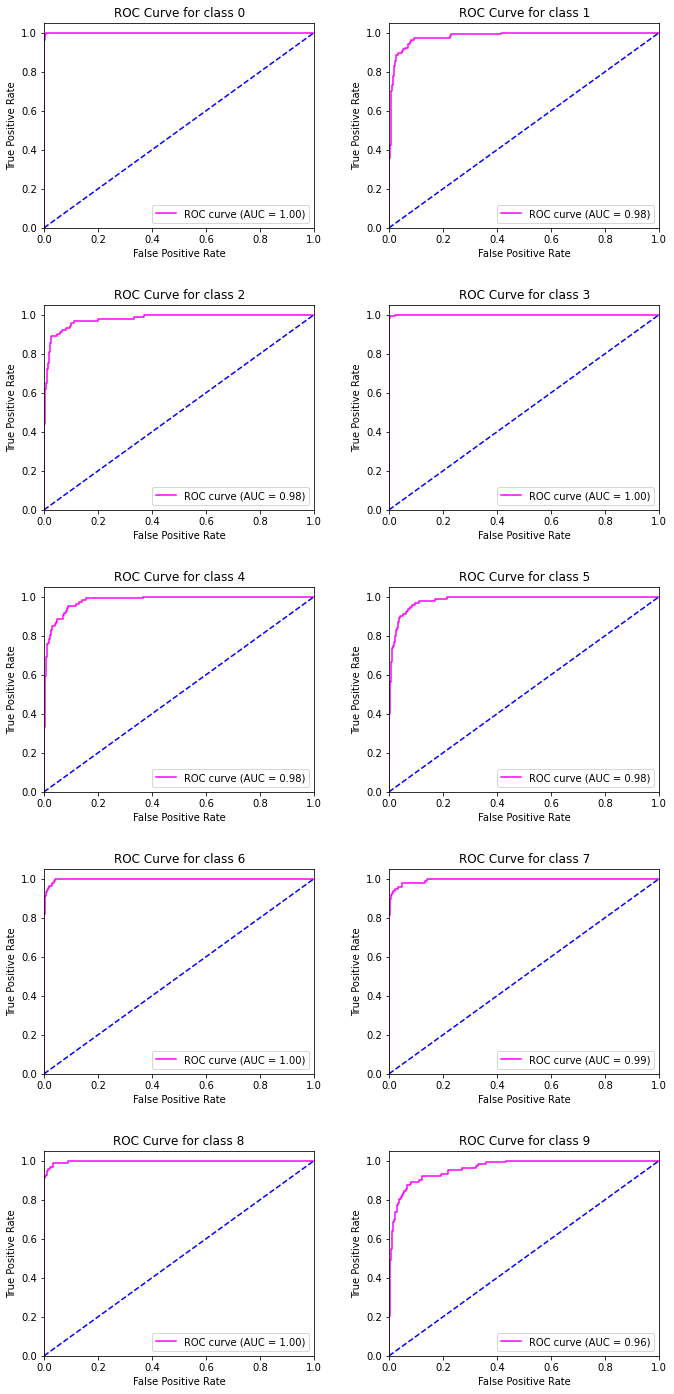

In [15]:
##Task1-Question3.d
from sklearn.metrics import roc_curve, auc
from itertools import cycle
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range (10) :
  fpr[i], tpr[i], _= roc_curve(y_testt[:,i], predicted[:,i])
  roc_auc[i] = auc(fpr[i], tpr[i]) 
plt.figure()
#colors = cycle(["red", "blue","green", "pink","yellow", "teal","gold","aqua", "darkorange", "cornflowerblue"])
fig, axs = plt.subplots(5, 2, figsize=(10, 20)) 
for i, ax in zip(range(10), axs.ravel()):
  ax.plot(fpr[i],tpr[i],color='magenta',label= 'ROC curve (AUC = %0.2f)' % roc_auc[i]) 
  ax.plot([0, 1], [0, 1], 'b--')
  ax.set_xlim([0.0, 1.0])
  ax.set_ylim([0.0, 1.05])
  ax.set_xlabel("False Positive Rate")
  ax.set_ylabel("True Positive Rate")
  ax.set_title('ROC Curve for class {}'. format(i)) 
  ax.legend(loc= "lower right")
  fig.tight_layout(pad=3.0)
plt.savefig('/content/drive/My Drive/torchray_master/roc_curve_MNIST1D.png')

In [16]:
# area under the curve (AUC) 
for i in range(10):
  print("The AUC of class "+ str(i)+" is "+str(roc_auc[i]))

The AUC of class 0 is 0.999836237390279
The AUC of class 1 is 0.9807477678571429
The AUC of class 2 is 0.9784531136299165
The AUC of class 3 is 0.9997256342070829
The AUC of class 4 is 0.9801401376049976
The AUC of class 5 is 0.9830987827503507
The AUC of class 6 is 0.9978475095012276
The AUC of class 7 is 0.99492994100295
The AUC of class 8 is 0.9975111996017919
The AUC of class 9 is 0.9616904668326127


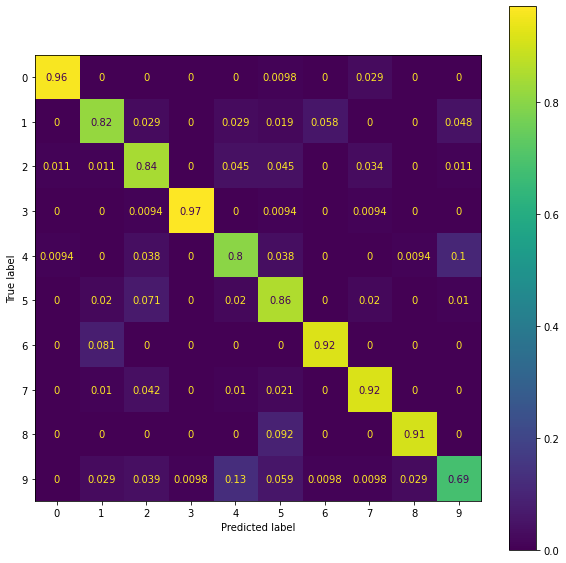

In [18]:
##Task1-Question3.e
fig, ax=plt.subplots(figsize=(10,10))
metrics.ConfusionMatrixDisplay.from_predictions(dataset['y_test'],predicted_class, normalize='true', ax=ax)
plt.savefig('/content/drive/My Drive/torchray_master/confusionMat_MNIST1D.png')

In [19]:
##Task1-Question3.f
precision, recall, f_1, _ = metrics.precision_recall_fscore_support(dataset['y_test'], predicted_class, average='micro')
print("For the whole data set, the scores are: ")
print("Precision: "+str(precision))
print("Recall: " +str(recall))
print("F-1: "+str(f_1))
print()

for i in range(10):
  precision, recall, f_1, _ = metrics.precision_recall_fscore_support(dataset['y_test'], predicted_class, labels=[i], average = 'micro')
  print("For class "+ str(i)+", the scores are:")
  print("Precision: "+str(precision))
  print("Recall: " +str(recall))
  print("F-1: "+str(f_1))
  print()

For the whole data set, the scores are: 
Precision: 0.868
Recall: 0.868
F-1: 0.868

For class 0, the scores are:
Precision: 0.98
Recall: 0.9607843137254902
F-1: 0.9702970297029702

For class 1, the scores are:
Precision: 0.85
Recall: 0.8173076923076923
F-1: 0.8333333333333334

For class 2, the scores are:
Precision: 0.7653061224489796
Recall: 0.8426966292134831
F-1: 0.8021390374331551

For class 3, the scores are:
Precision: 0.9903846153846154
Recall: 0.9716981132075472
F-1: 0.9809523809523809

For class 4, the scores are:
Precision: 0.7870370370370371
Recall: 0.8018867924528302
F-1: 0.794392523364486

For class 5, the scores are:
Precision: 0.7433628318584071
Recall: 0.8571428571428571
F-1: 0.7962085308056872

For class 6, the scores are:
Precision: 0.9285714285714286
Recall: 0.9191919191919192
F-1: 0.9238578680203046

For class 7, the scores are:
Precision: 0.8979591836734694
Recall: 0.9166666666666666
F-1: 0.9072164948453607

For class 8, the scores are:
Precision: 0.956989247311828

In [20]:
##Task1-Question4
import collections
Error_list=[]#indecies of mis-predicted samples in data set
True_list=[]#indecies of correctly classified samples 

for i,tp in zip(range(len(dataset['y_test'])), (dataset['y_test']==predicted_class)):
  if(tp==True):
    True_list.append(i)
  else:
    Error_list.append(i)

Error_list_Truelabels=[]
for i in range(len(Error_list)):
  Error_list_Truelabels.append(dataset['y_test'][Error_list[i]])

frequencies=collections.Counter(Error_list_Truelabels)
print("Error for each class in decreasing order w.r.t. number of error:")
print(frequencies)
print()

Error for each class in decreasing order w.r.t. number of error:
Counter({9: 32, 4: 21, 1: 19, 5: 14, 2: 14, 8: 9, 7: 8, 6: 8, 0: 4, 3: 3})



In [21]:
mismatch_9=[]
for i in range(len(Error_list_Truelabels)):
  if(Error_list_Truelabels[i]==9):
    mismatch_9.append(predicted_class[Error_list[i]])
print("List of false classification for Class 9: ")
print(mismatch_9)
print()
# 10->8, 7->4
mismatch_2=[]
for i in range(len(Error_list_Truelabels)):
  if(Error_list_Truelabels[i]==2):
    mismatch_2.append(predicted_class[Error_list[i]])
print("List of false classification for Class 2: ")
print(mismatch_2)
# 9->7, 4->5, 

List of false classification for Class 9: 
[4, 8, 5, 4, 4, 4, 5, 4, 8, 8, 2, 5, 7, 4, 2, 4, 4, 1, 5, 4, 5, 6, 1, 1, 4, 3, 4, 4, 2, 4, 2, 5]

List of false classification for Class 2: 
[7, 4, 4, 9, 4, 4, 5, 0, 7, 5, 5, 7, 5, 1]


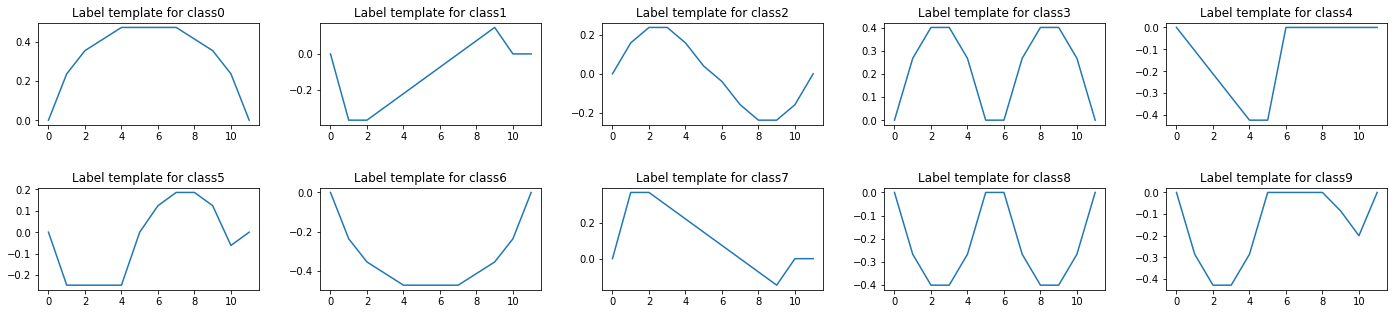

<Figure size 432x288 with 0 Axes>

In [22]:
#All templates:
fig, axs= plt.subplots(2,5,figsize=(20,5))
for i, ax in zip(range(10),axs.ravel()):
  ax.plot(dataset['templates']['x'][i])
  ax.set_title('Label template for class'+ str(i))
plt.tight_layout(pad=3.0)
plt.show()
plt.savefig('/content/drive/My Drive/torchray_master/templates_MNIST1D.png')

# **Some  examples  of failure  cases:**

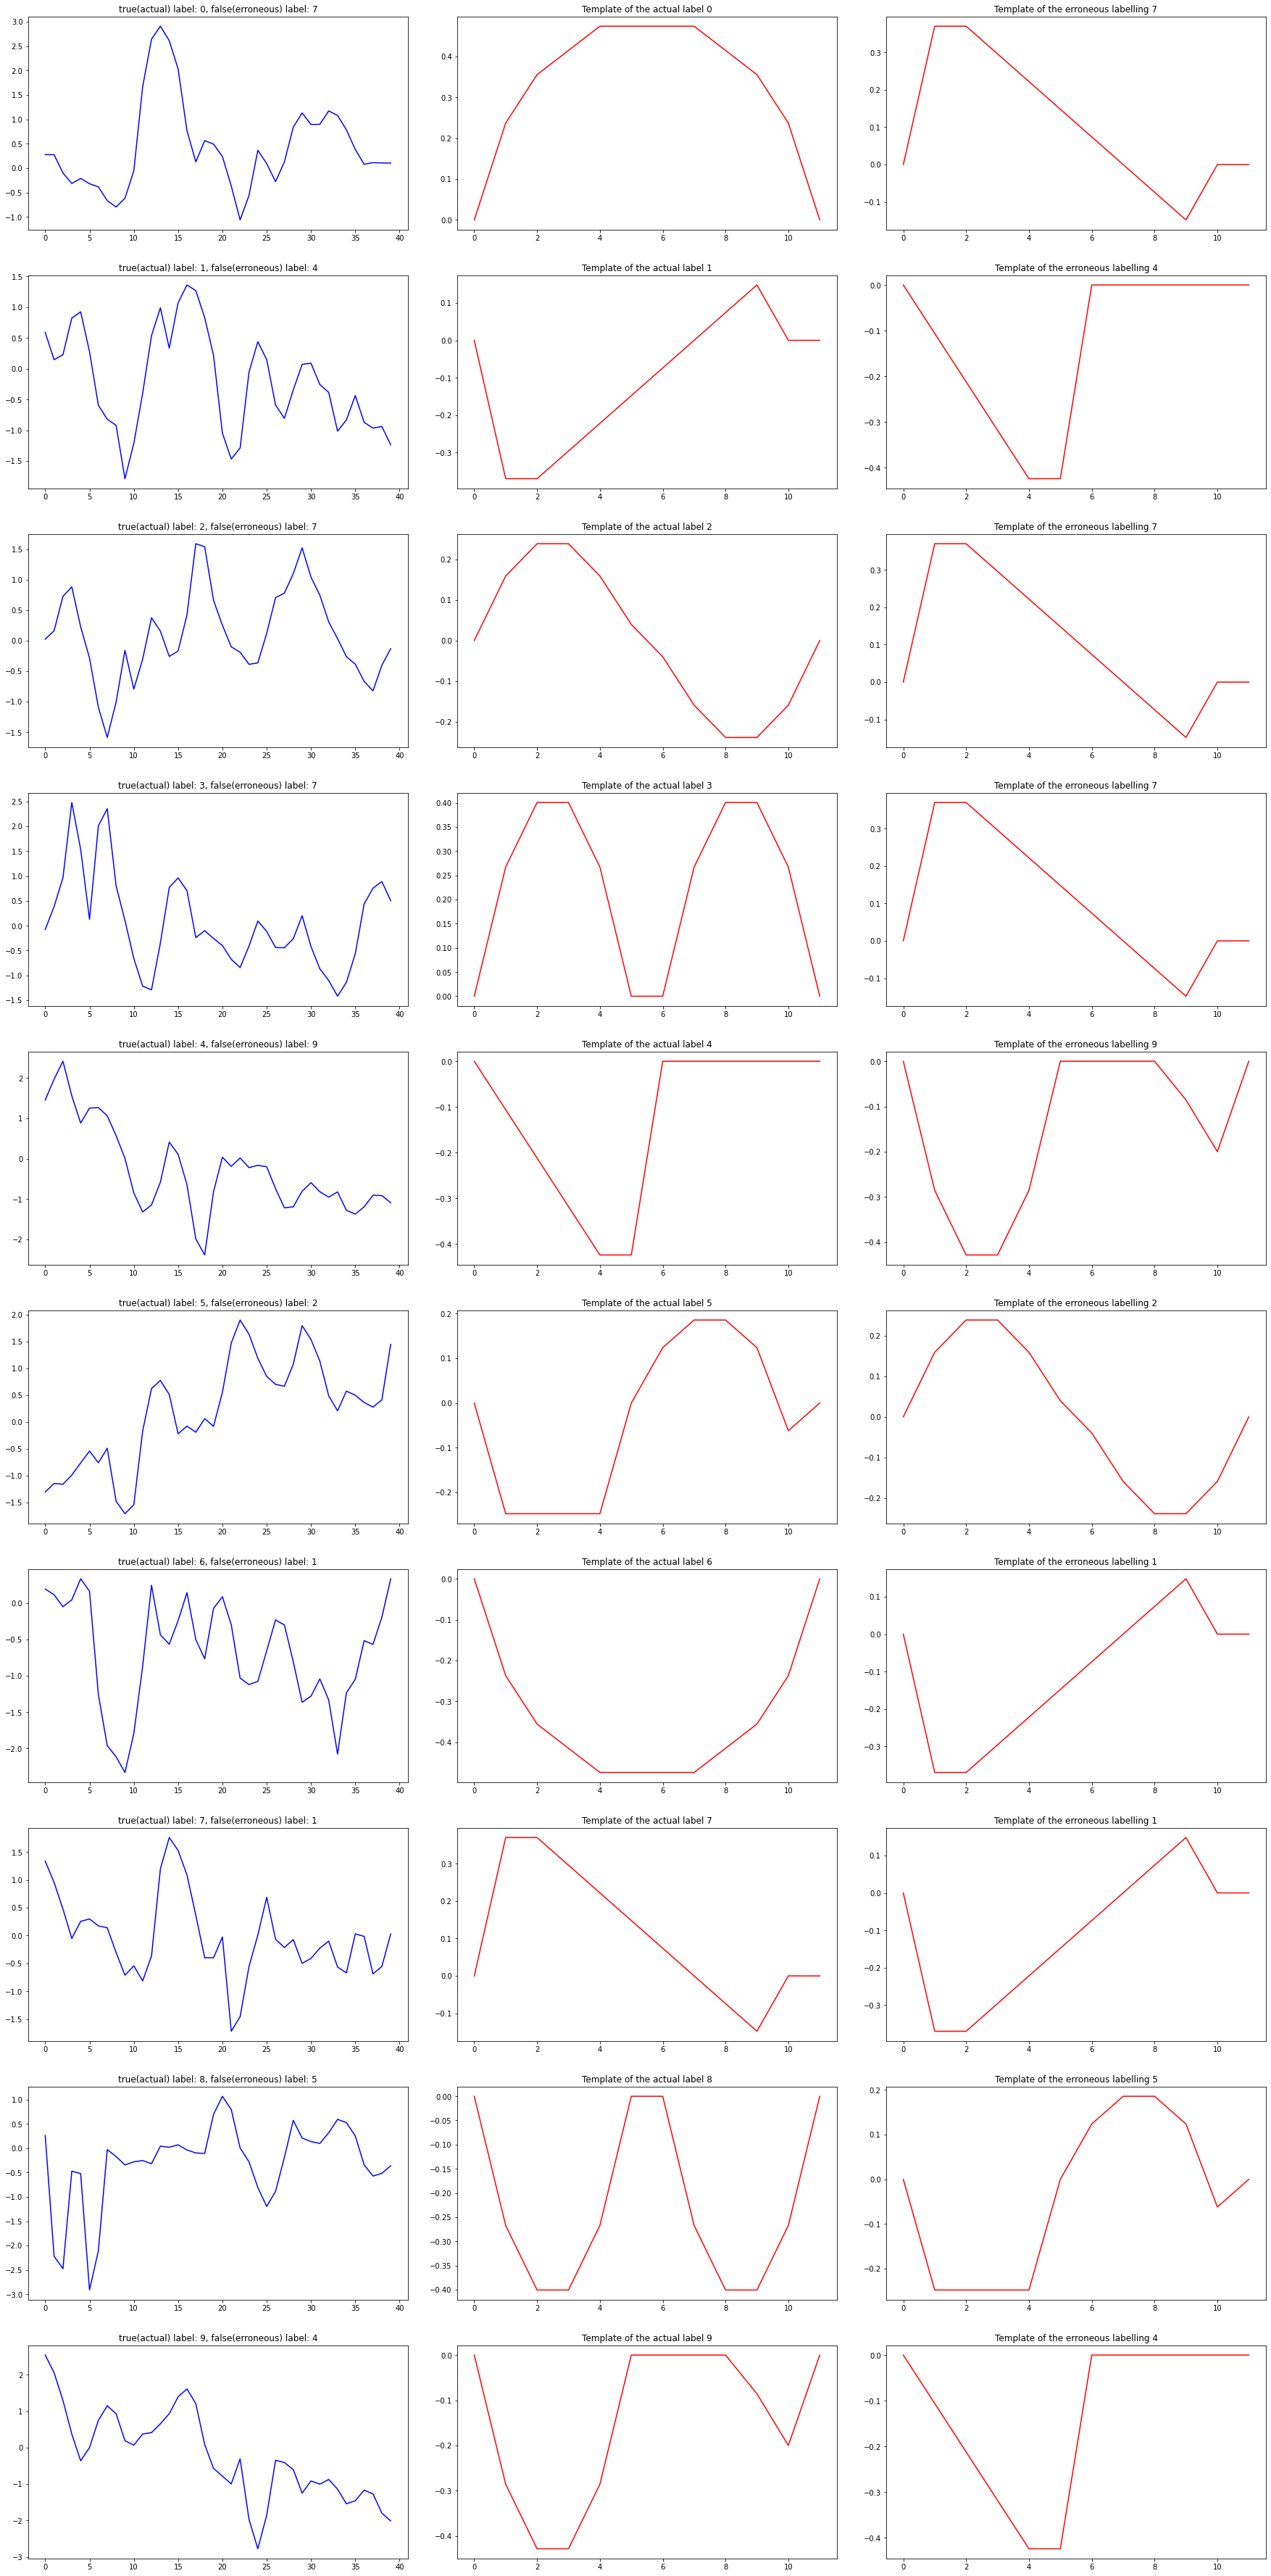

<Figure size 432x288 with 0 Axes>

In [23]:
fig, axs= plt.subplots(10,3,figsize=(25,50))
for i in range(10):
  if not i in Error_list_Truelabels:
    print("no false prediction for class "+str(i))
  else:
    index=Error_list_Truelabels.index(i) #get sample number
    axs[i,0].plot(dataset['x_test'][Error_list[index]], 'b') #plot the sample
    axs[i,0].set_title('true(actual) label: '+str(dataset['y_test'][Error_list[index]]) +', false(erroneous) label: '+ str(predicted_class[Error_list[index]]))
    axs[i,1].plot(dataset['templates']['x'][dataset['y_test'][Error_list[index]]], 'r') #plot the template for the sample
    axs[i,1].set_title('Template of the actual label '+ str(dataset['y_test'][Error_list[index]]))
    axs[i,2].plot(dataset['templates']['x'][predicted_class[Error_list[index]]], 'r') #plot the template of the mismatched class
    axs[i,2].set_title('Template of the erroneous labelling '+ str(predicted_class[Error_list[index]]))
plt.tight_layout(pad=3.0)
plt.show()
plt.savefig('/content/drive/My Drive/torchray_master/failures_MNIST1D.png')

### **Some  examples  of success  cases:**

In [24]:
True_list_labels=[]
for i in range(len(Error_list)):
  True_list_labels.append(dataset['y_test'][True_list[i]])
  

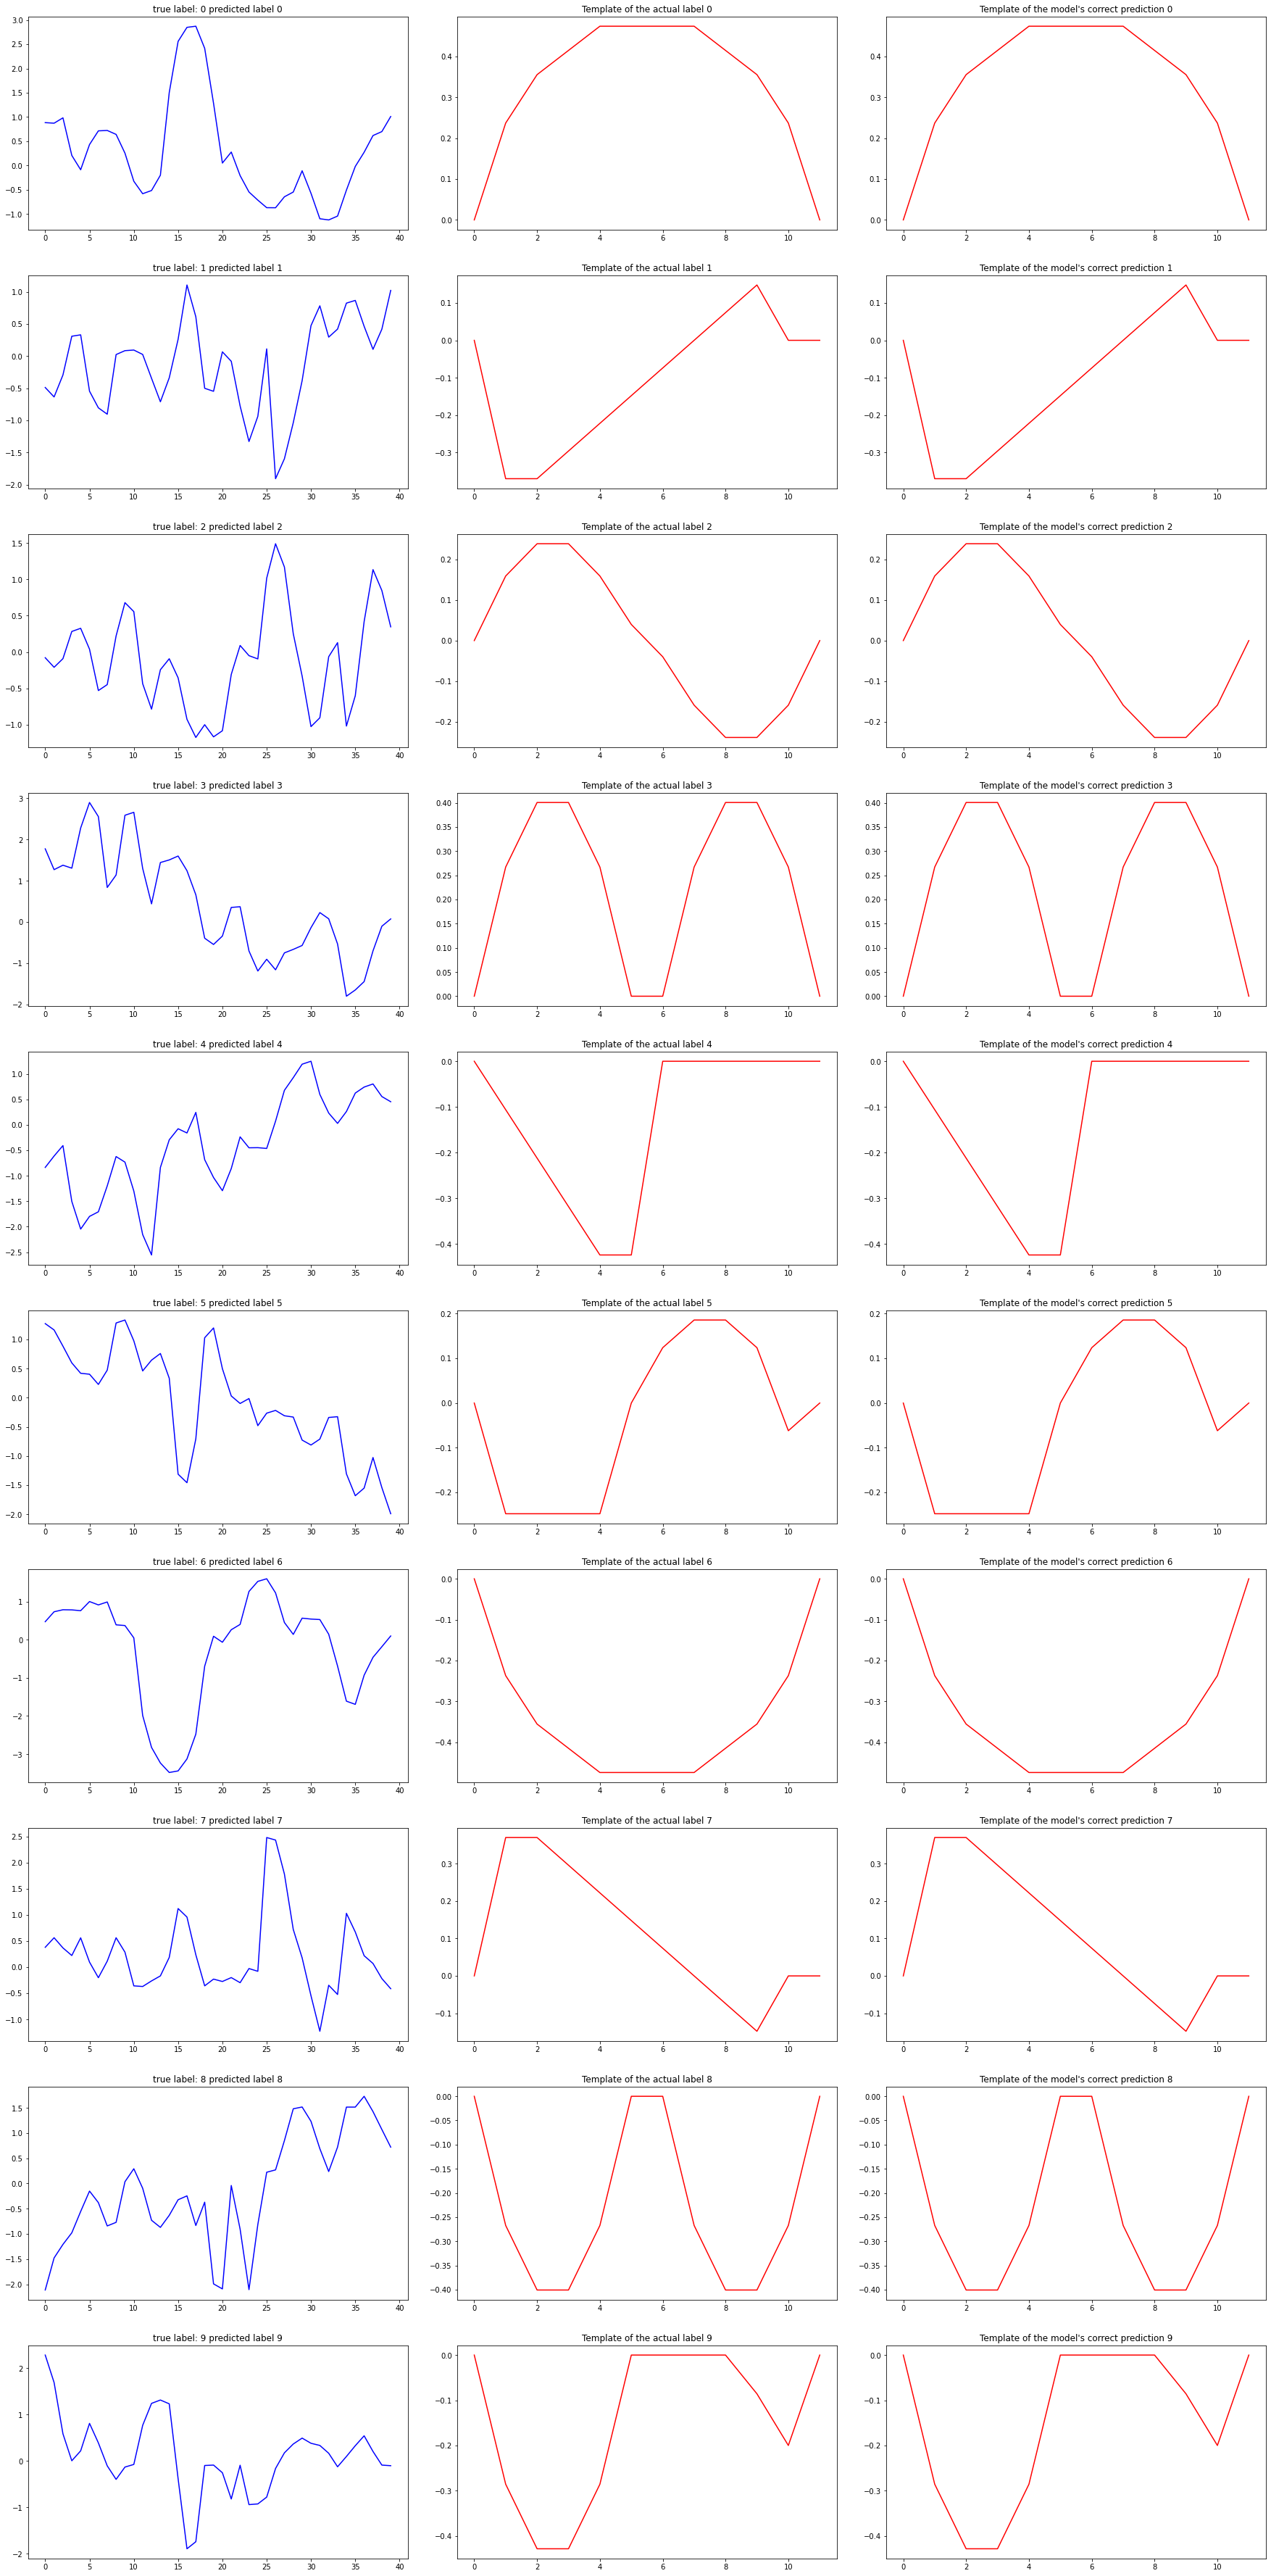

<Figure size 432x288 with 0 Axes>

In [25]:
fig, axs= plt.subplots(10,3,figsize=(25,50))
for i in range(10):
  index=True_list_labels.index(i) #get sample number
  axs[i,0].plot(dataset['x_test'][True_list[index]], 'b') #plot the sample
  axs[i,0].set_title('true label: '+str(dataset['y_test'][True_list[index]]) +' predicted label '+ str(predicted_class[True_list[index]]))
  axs[i,1].plot(dataset['templates']['x'][dataset['y_test'][True_list[index]]], 'r') #plot the template for the sample
  axs[i,1].set_title('Template of the actual label '+ str(dataset['y_test'][True_list[index]]))
  axs[i,2].plot(dataset['templates']['x'][predicted_class[True_list[index]]], 'r') #plot the template of the mismatched class
  axs[i,2].set_title('Template of the model\'s correct prediction '+ str(predicted_class[True_list[index]]))
plt.tight_layout(pad=3.0)
plt.show()
plt.savefig('/content/drive/My Drive/torchray_master/success_MNIST1D.png')


# Explanation

In [26]:
from xai_utils import *

Take a test sample

In [27]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give input to the model (Prediction)

In [28]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.9999999


## SISE (Semantic Input Sampling for Explanation)

In [29]:
explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)

Text(0.5, 1.0, 'Highlighted input region (by the SISE algorithm)')

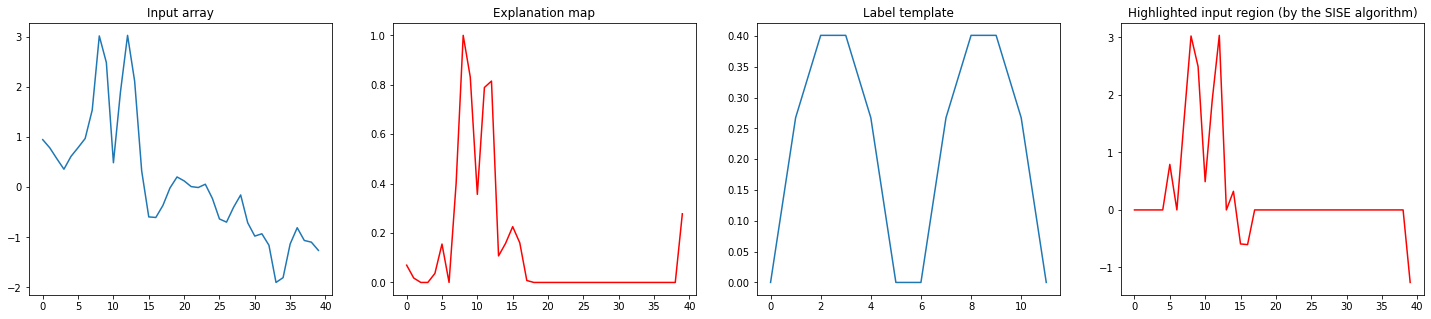

In [30]:
threshold = np.sort(explanation[:,0])[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the SISE algorithm)')

## **For some correct predictions:**

Correctly Predicted digit: 0
Confidence score for the correct label: 0.999995

Correctly Predicted digit: 1
Confidence score for the correct label: 0.9402456

Correctly Predicted digit: 2
Confidence score for the correct label: 0.9233375

Correctly Predicted digit: 3
Confidence score for the correct label: 0.9998522

Correctly Predicted digit: 4
Confidence score for the correct label: 0.7754513

Correctly Predicted digit: 5
Confidence score for the correct label: 0.9728247

Correctly Predicted digit: 6
Confidence score for the correct label: 0.9999981

Correctly Predicted digit: 7
Confidence score for the correct label: 0.989852

Correctly Predicted digit: 8
Confidence score for the correct label: 0.99973756

Correctly Predicted digit: 9
Confidence score for the correct label: 0.9844051



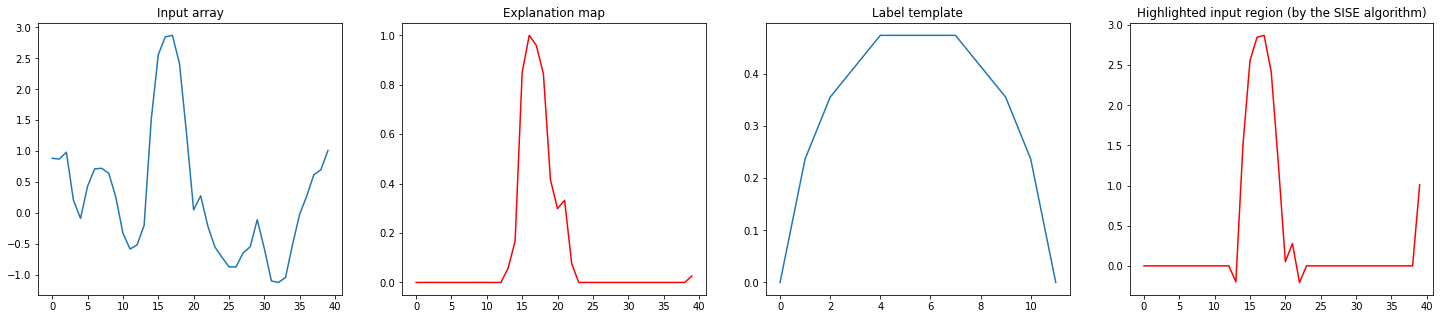

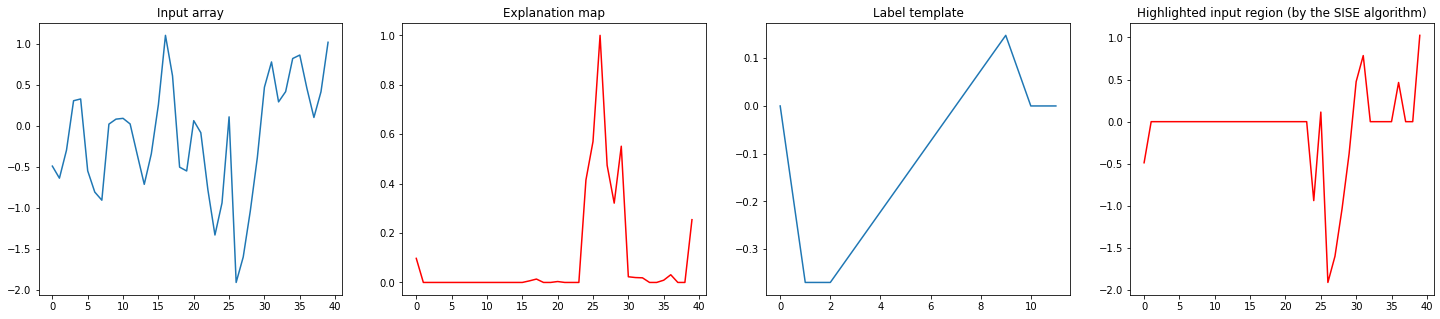

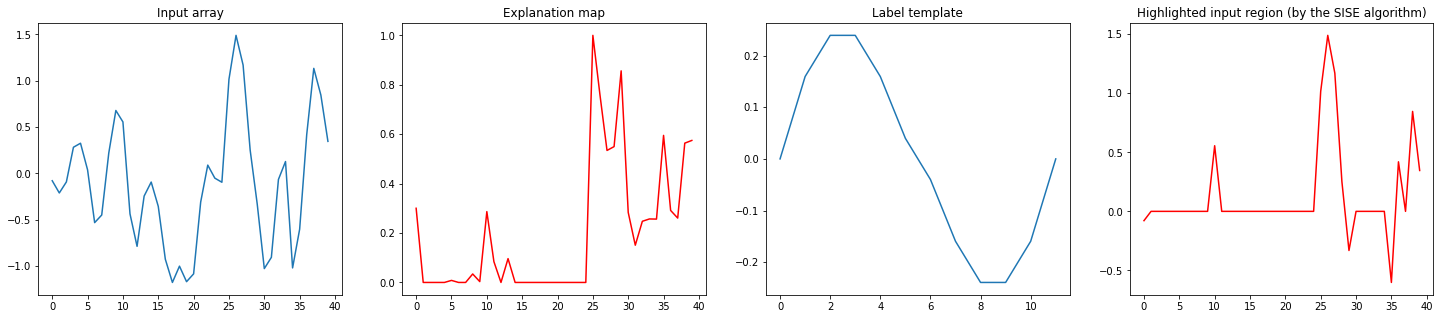

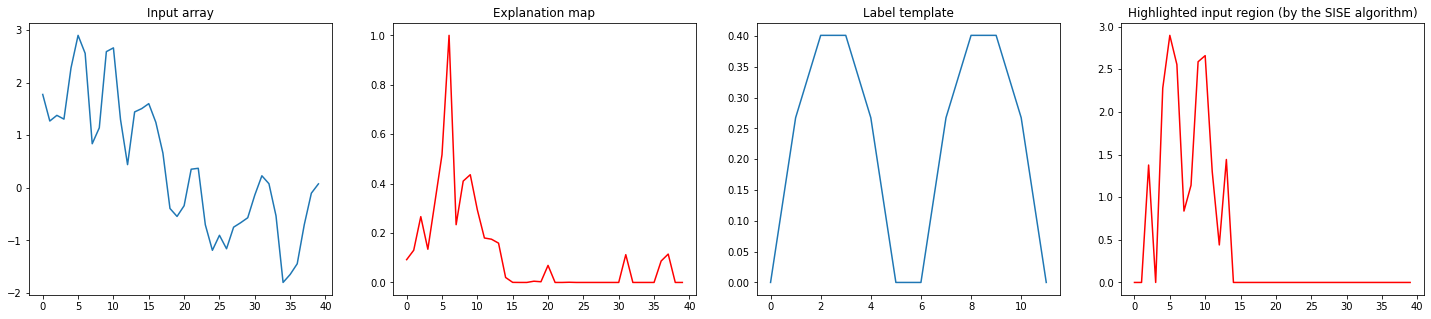

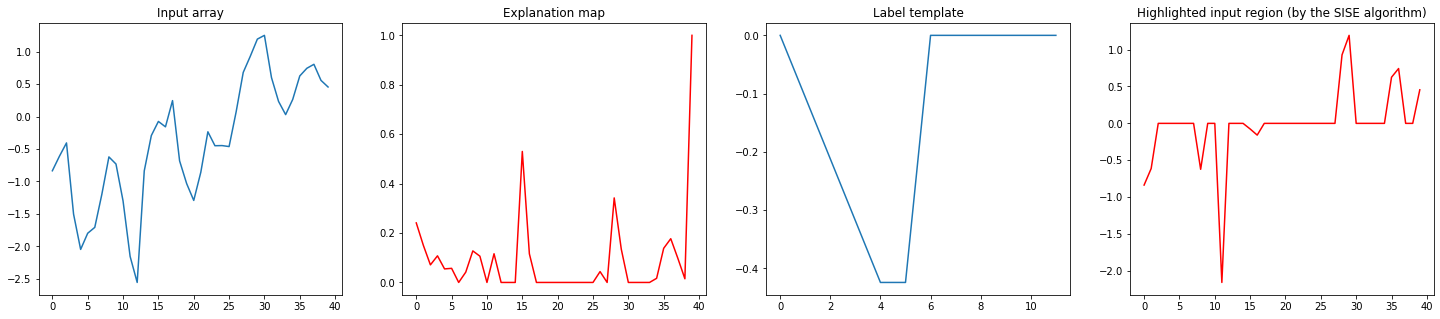

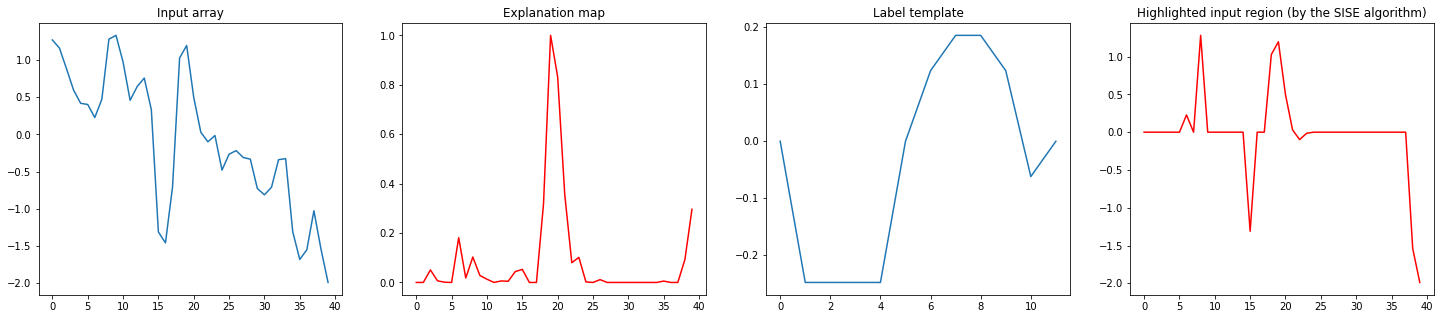

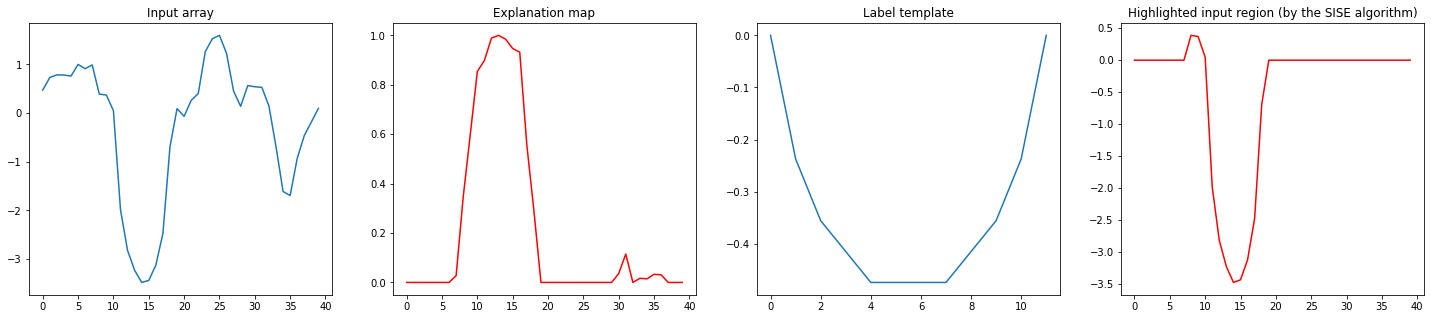

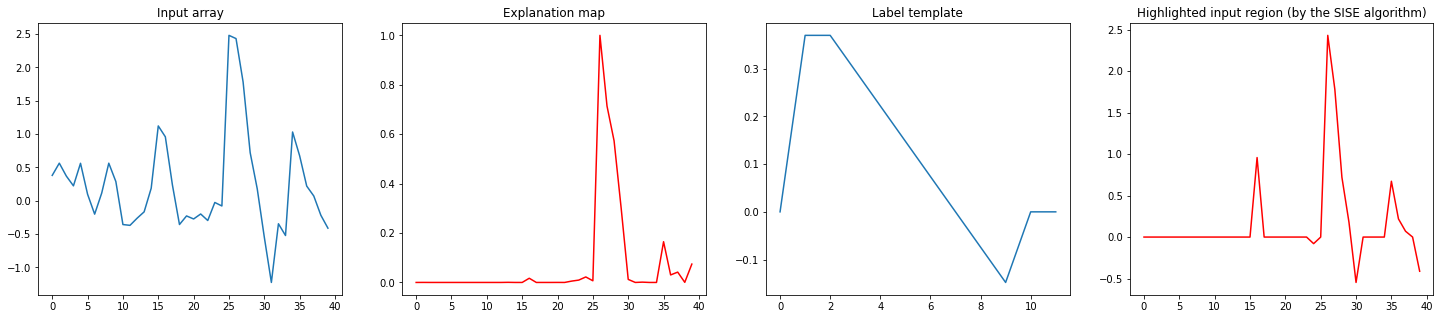

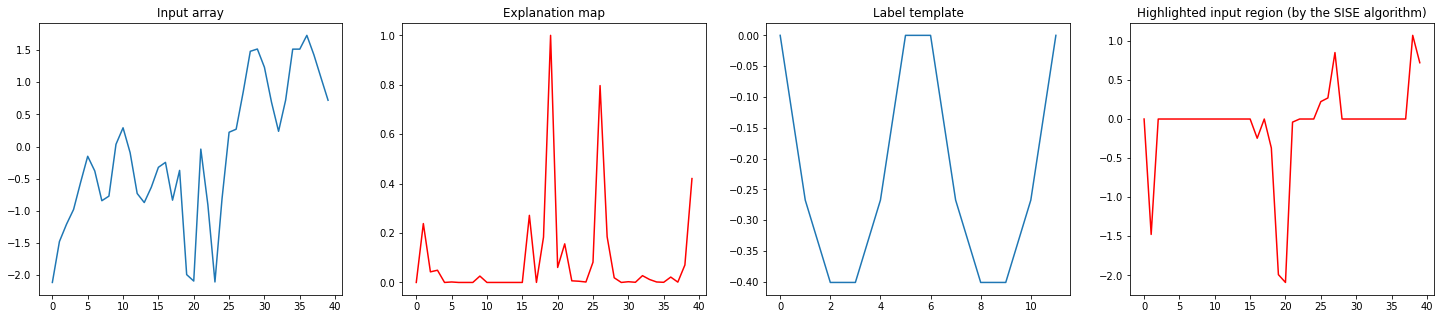

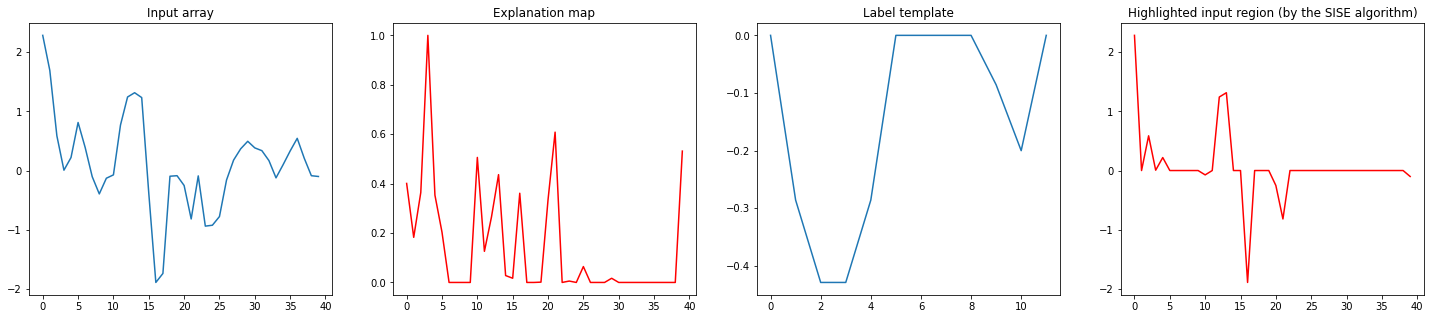

In [31]:
for i in range(10):
  index=True_list_labels.index(i)
  index=True_list[index]
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = y_test[index]
  # print("input")
  #print('Correct digit: '+str(label))
  print('Correctly Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  print()
  explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
  threshold = np.sort(explanation[:,0])[-12]

  plt.figure(figsize=(25,5))

  plt.subplot(1,4,1)
  plt.plot(input[0])
  plt.title('Input array')

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map')

  plt.subplot(1,4,3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Label template')

  plt.subplot(1,4,4)
  plt.plot((input[0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the SISE algorithm)')

plt.savefig('/content/drive/My Drive/torchray_master/correct_sise_MNIST1D.png')

# **For wrong predictions:**

wrong prediction
Correct digit: 0
Predicted digit: 7
Confidence score for the correct label: 0.45365363

wrong prediction
Correct digit: 1
Predicted digit: 4
Confidence score for the correct label: 0.24164952

wrong prediction
Correct digit: 2
Predicted digit: 7
Confidence score for the correct label: 0.17883982

wrong prediction
Correct digit: 3
Predicted digit: 7
Confidence score for the correct label: 0.3431074

wrong prediction
Correct digit: 4
Predicted digit: 9
Confidence score for the correct label: 0.1019726

wrong prediction
Correct digit: 5
Predicted digit: 2
Confidence score for the correct label: 0.30337694

wrong prediction
Correct digit: 6
Predicted digit: 1
Confidence score for the correct label: 0.03538563

wrong prediction
Correct digit: 7
Predicted digit: 1
Confidence score for the correct label: 0.0030102963

wrong prediction
Correct digit: 8
Predicted digit: 5
Confidence score for the correct label: 0.03396985

wrong prediction
Correct digit: 9
Predicted digit: 4
Co

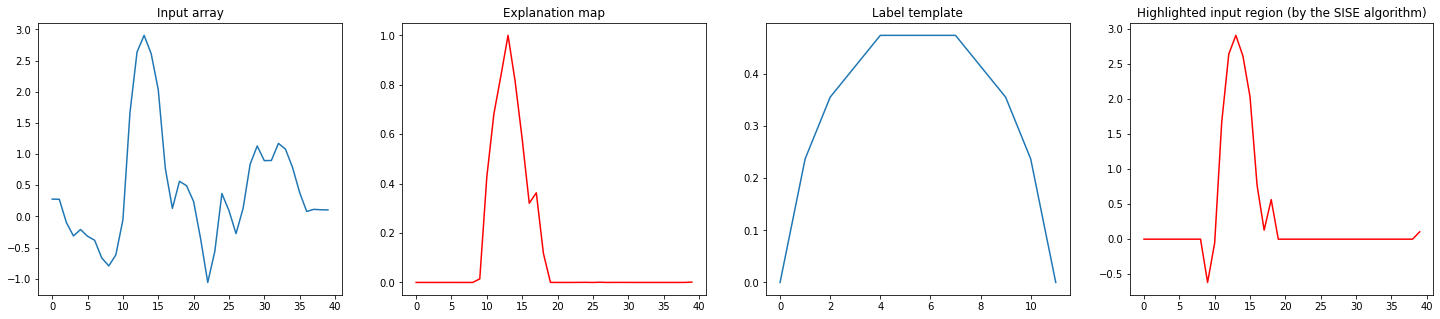

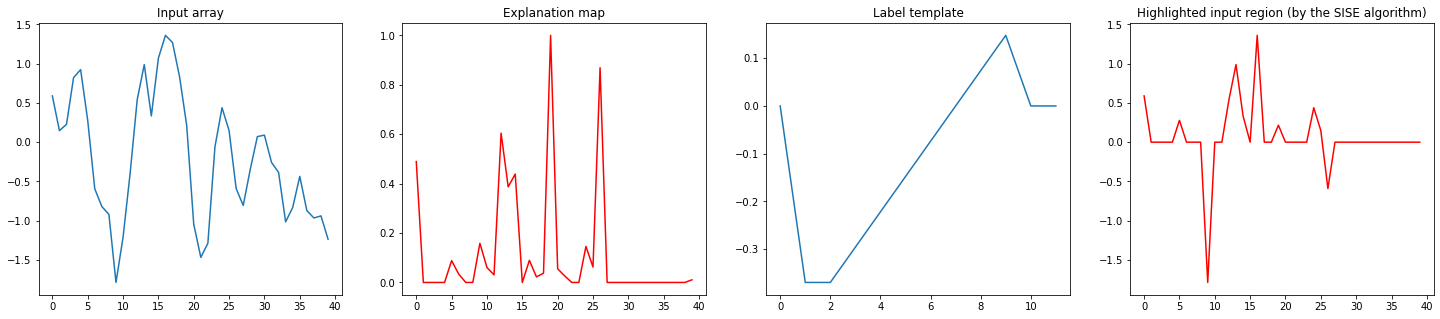

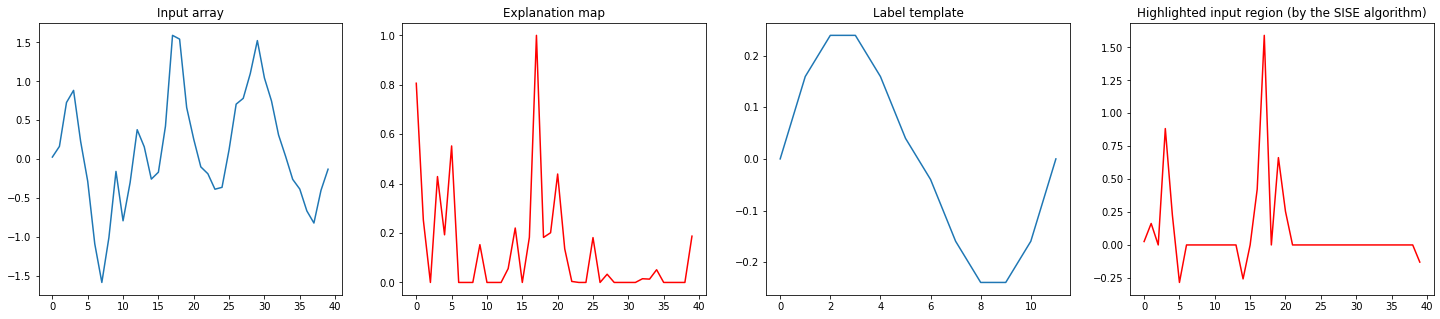

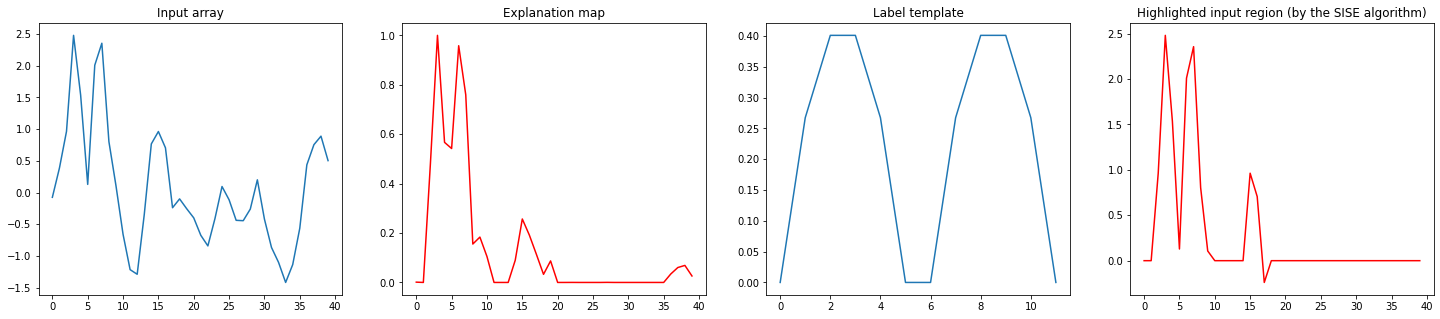

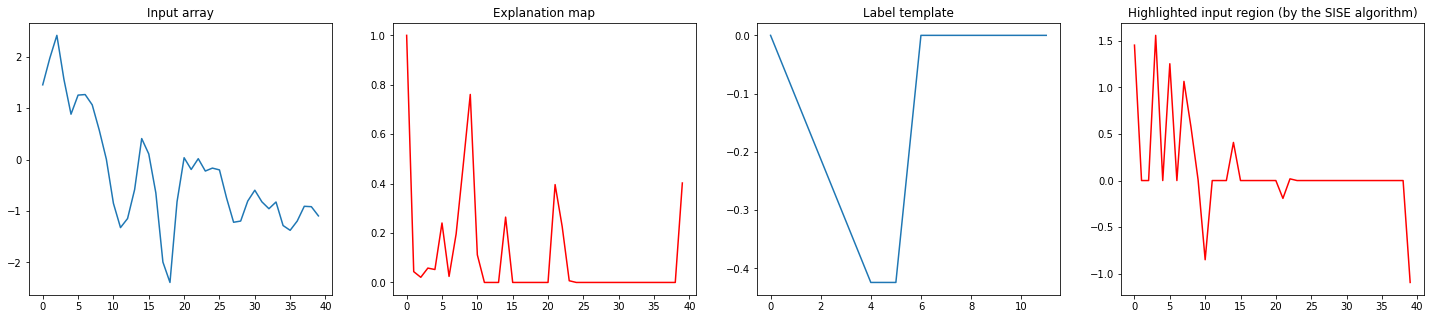

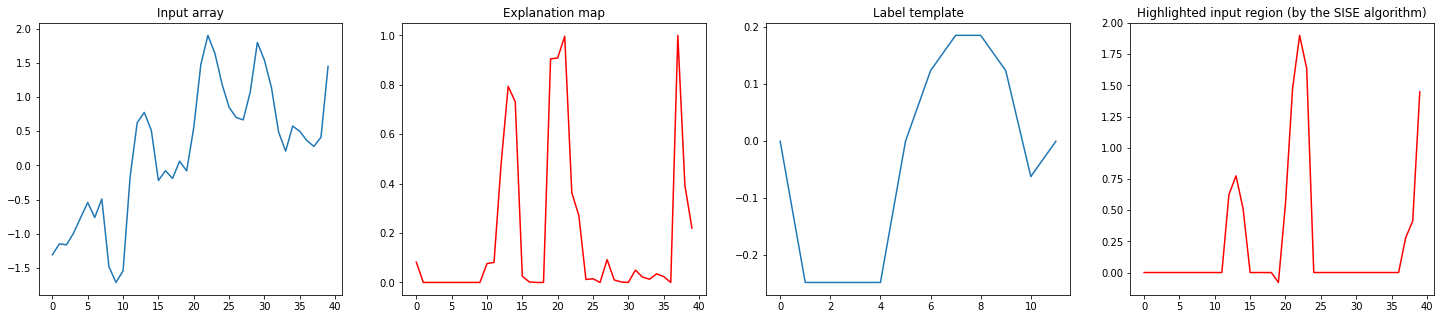

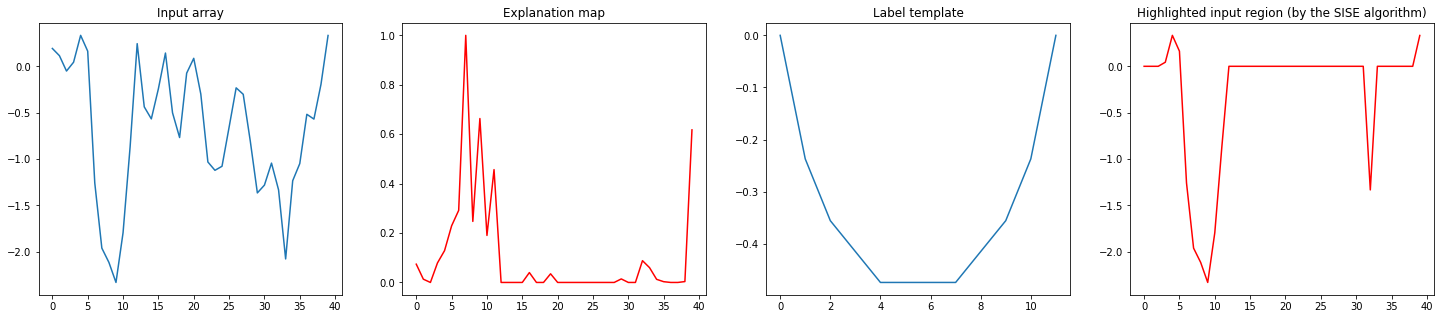

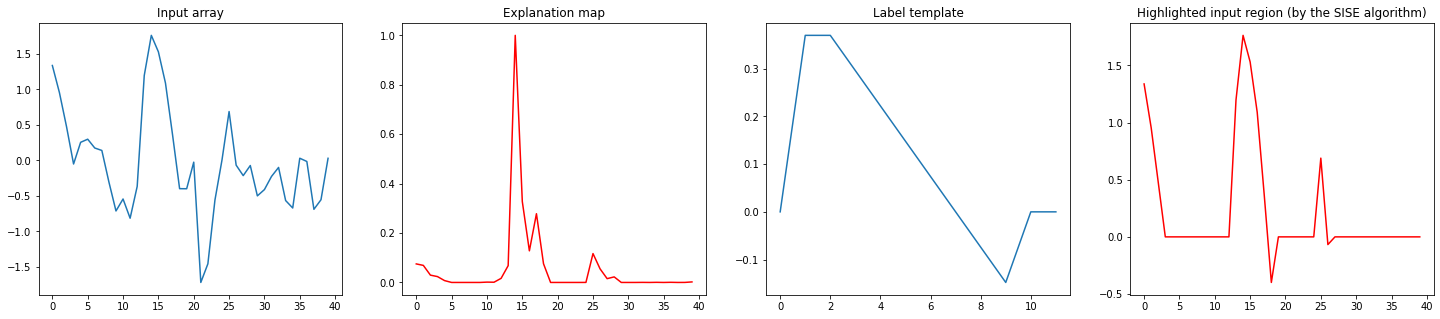

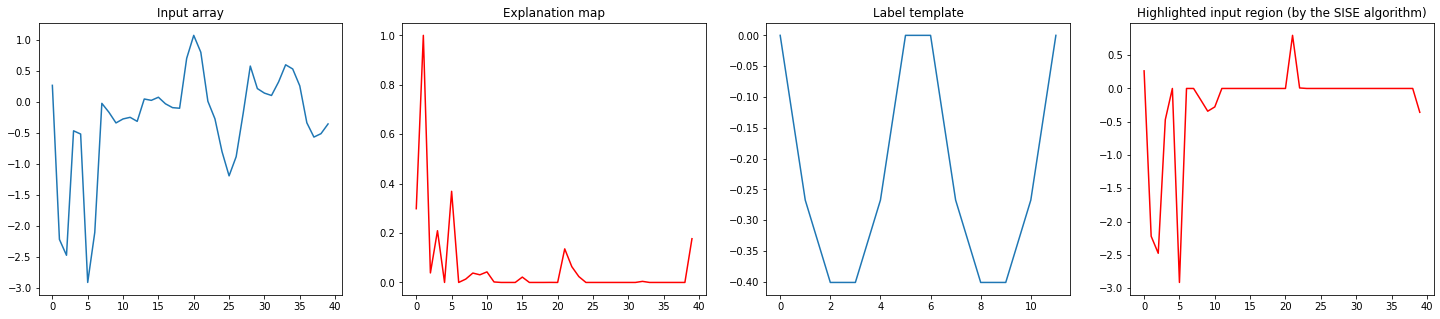

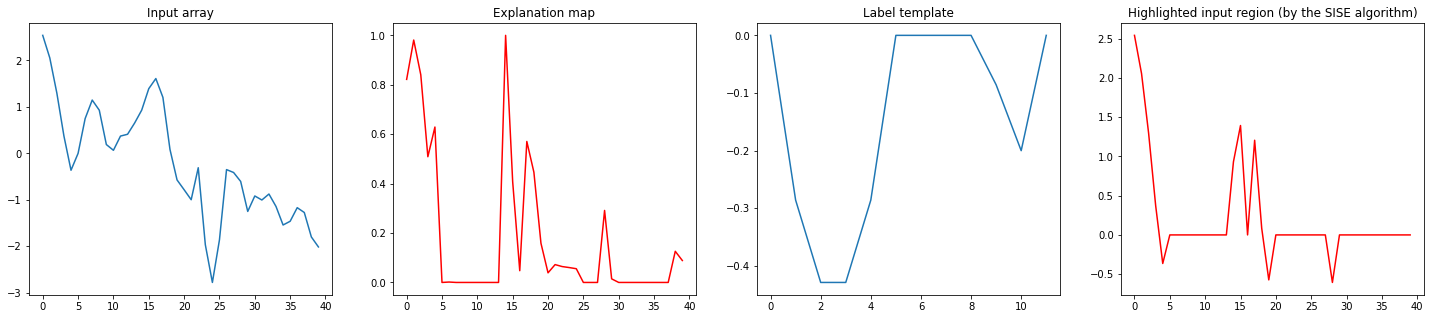

In [32]:
for i in range(10):
  if not i in Error_list_Truelabels:
    continue
  else:
    index=Error_list_Truelabels.index(i)
    index=Error_list[index]
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    print("wrong prediction")
    print('Correct digit: '+str(label))
    print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
    print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
    print()
    explanation = SISE(input, model, label, [['conv1d_2']], grad_thr=0.)
    threshold = np.sort(explanation[:,0])[-12]

    plt.figure(figsize=(25,5))

    plt.subplot(1,4,1)
    plt.plot(input[0])
    plt.title('Input array')

    plt.subplot(1,4,2)
    plt.plot(explanation, 'r')
    plt.title('Explanation map')

    plt.subplot(1,4,3)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')

    plt.subplot(1,4,4)
    plt.plot((input[0]*(explanation>threshold)), 'r')
    plt.title('Highlighted input region (by the SISE algorithm)')
plt.savefig('/content/drive/My Drive/torchray_master/wrong_and_sise_MNIST1D.png')

#### **Integrated-Gradient**

In [33]:
def Integrated_gradient(input, model, label, knots=range(50)):
  baseline = np.zeros(input.shape)
  path = np.asarray([baseline + (i/(knots[-1]+1))*(input-baseline) for i in knots]) 

  with tensorflow.GradientTape() as tape:
    inputs = tensorflow.cast(path, tensorflow.float32) 
    tape.watch(inputs)
    predictions = model(inputs)
    loss = predictions[:, label]

  
  grads = tape.gradient(loss, inputs)
  grads = (grads[:-1] + grads[1:])/ 2.0
  integrated_gradients = (input-baseline)*np.average(grads, axis=0) 

  return integrated_gradients

Text(0.5, 1.0, 'Highlighted input region (by the  algorithm)')

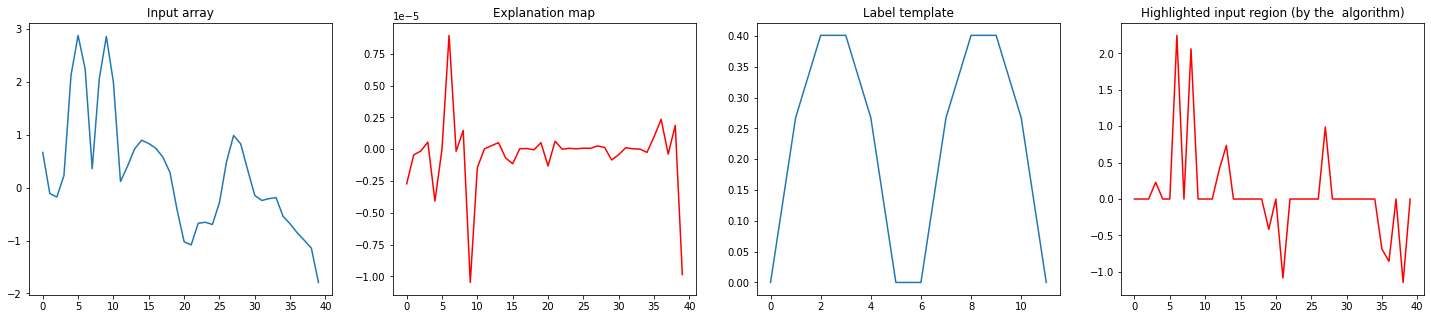

In [34]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1) 
label = y_test[index]
explanation = Integrated_gradient(input.flatten(),model,0)

threshold = np.sort(explanation)[-12]

plt.figure(figsize=(25,5))

plt.subplot(1,4,1)
plt.plot(input[0])
plt.title('Input array')

plt.subplot(1,4,2)
plt.plot(explanation, 'r')
plt.title('Explanation map')

plt.subplot(1,4,3)
plt.plot(dataset['templates']['x'][label])
plt.title('Label template')

plt.subplot(1,4,4)
plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
plt.title('Highlighted input region (by the  algorithm)')

## **For some correct predictions:**

Correctly Predicted digit: 0
Confidence score for the correct label: 0.999995

Correctly Predicted digit: 1
Confidence score for the correct label: 0.9402456

Correctly Predicted digit: 2
Confidence score for the correct label: 0.9233375

Correctly Predicted digit: 3
Confidence score for the correct label: 0.9998522

Correctly Predicted digit: 4
Confidence score for the correct label: 0.7754513

Correctly Predicted digit: 5
Confidence score for the correct label: 0.9728247

Correctly Predicted digit: 6
Confidence score for the correct label: 0.9999981

Correctly Predicted digit: 7
Confidence score for the correct label: 0.989852

Correctly Predicted digit: 8
Confidence score for the correct label: 0.99973756

Correctly Predicted digit: 9
Confidence score for the correct label: 0.9844051



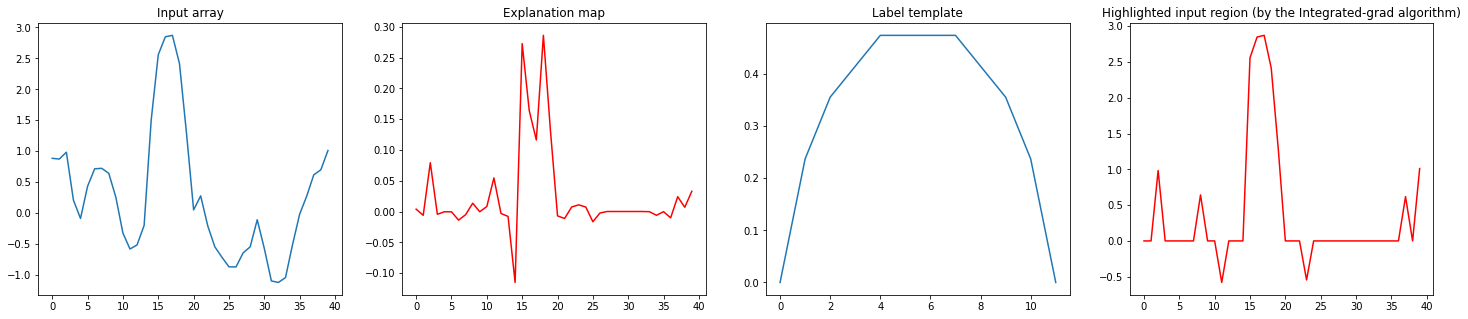

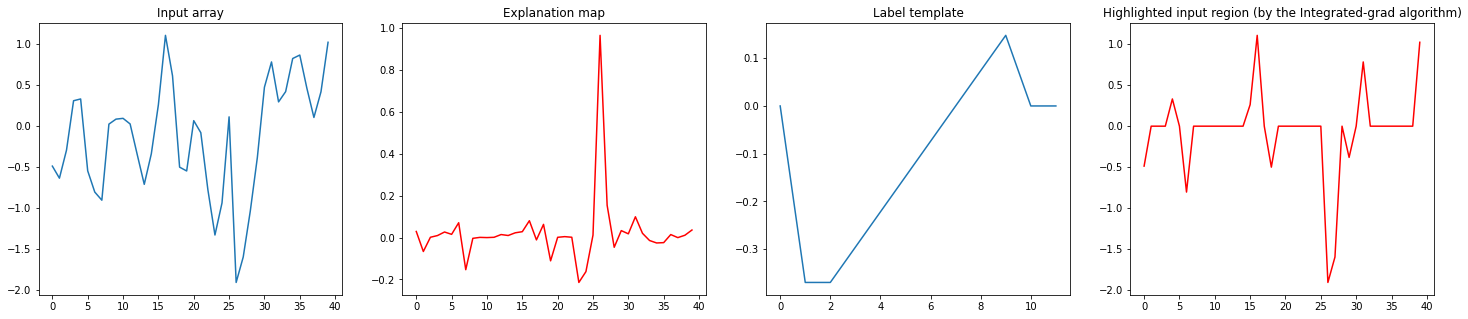

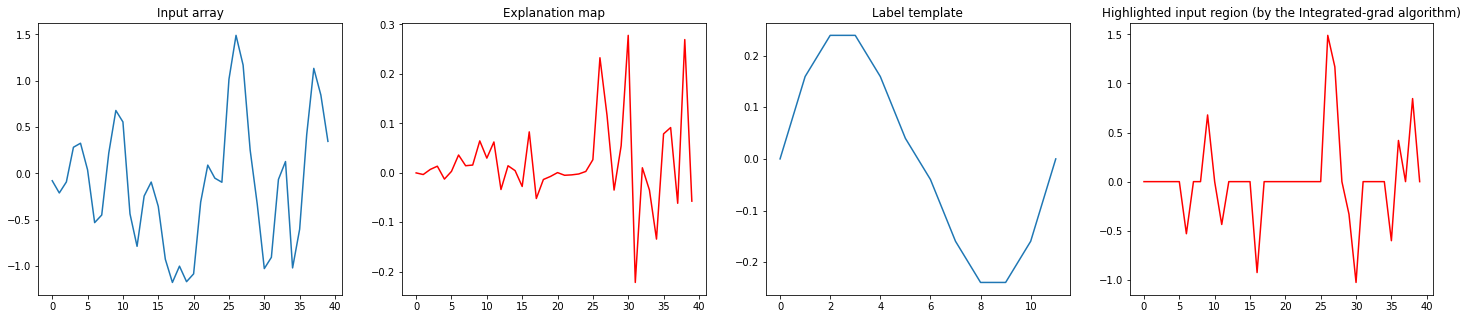

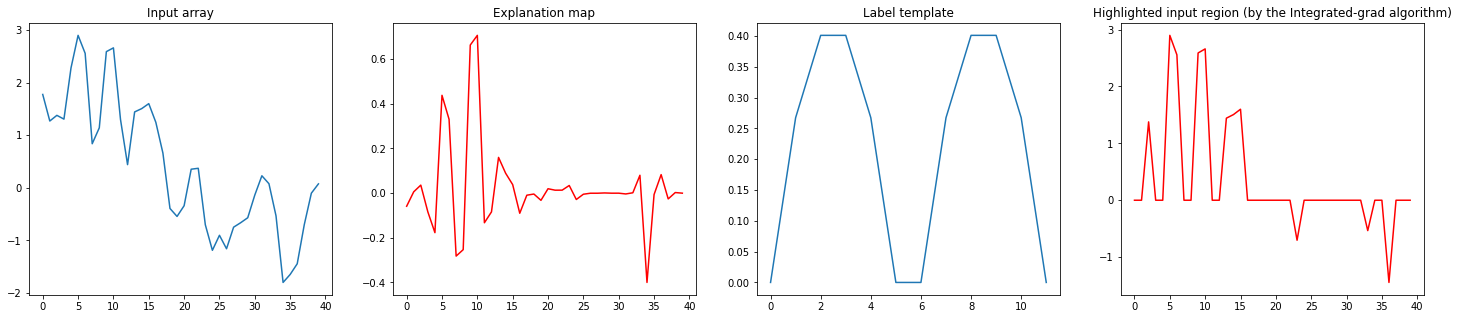

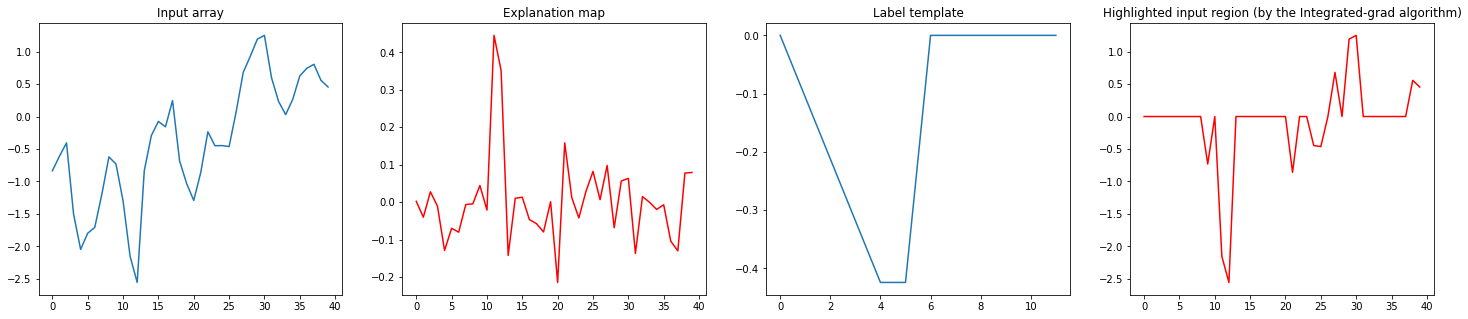

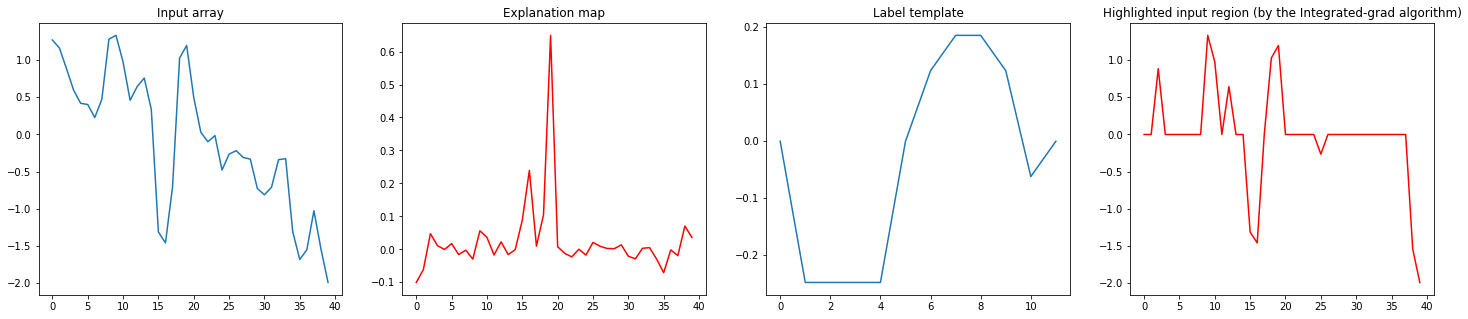

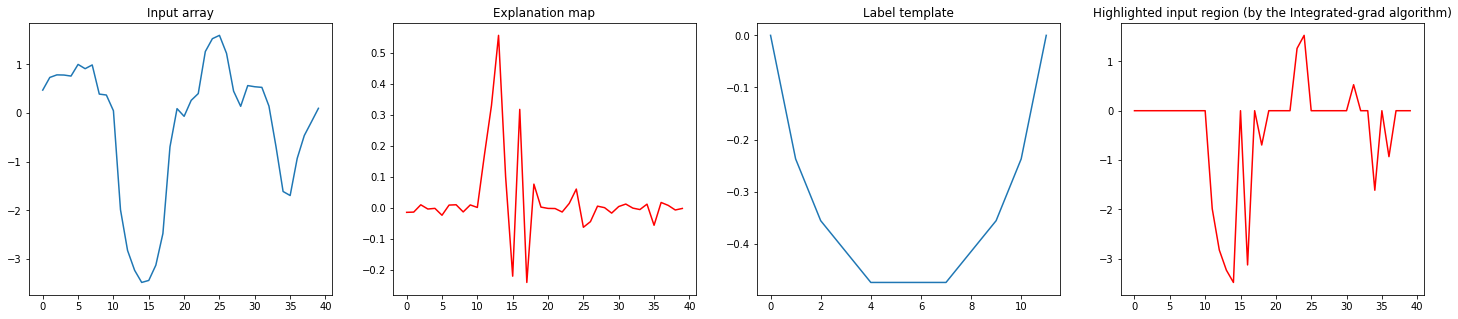

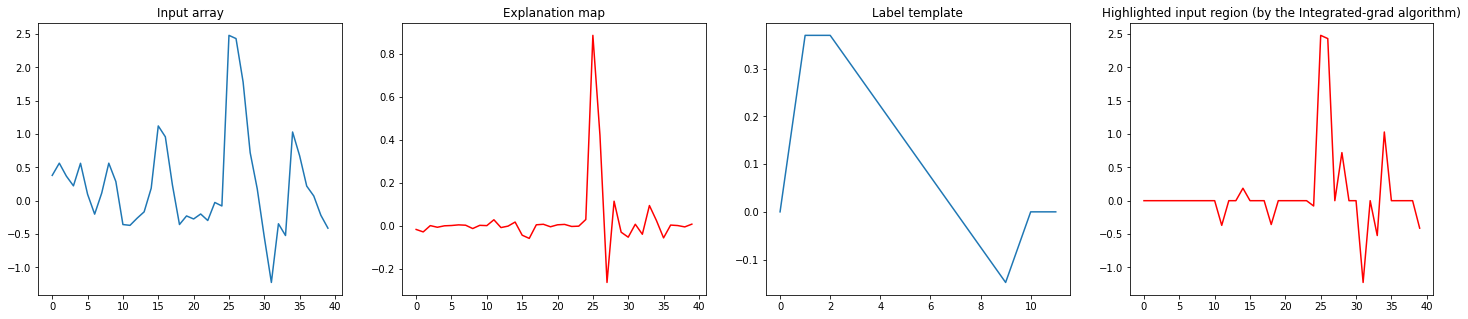

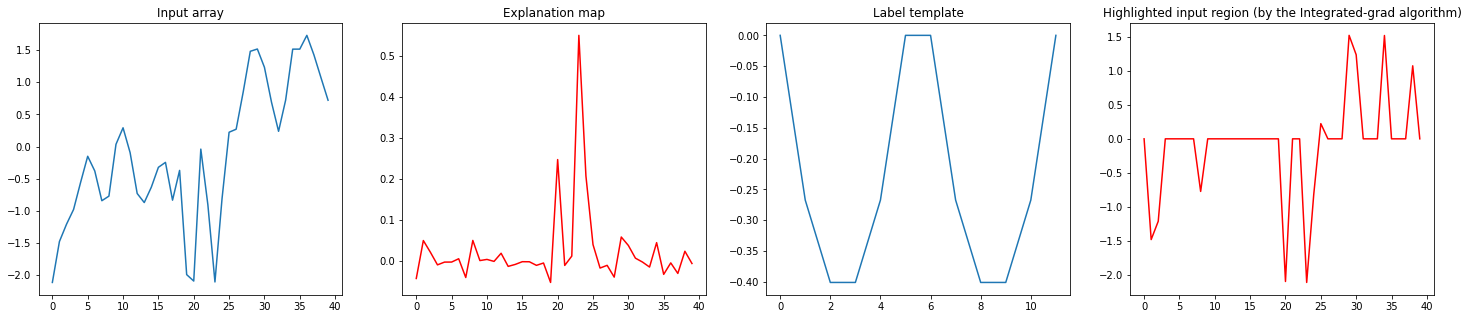

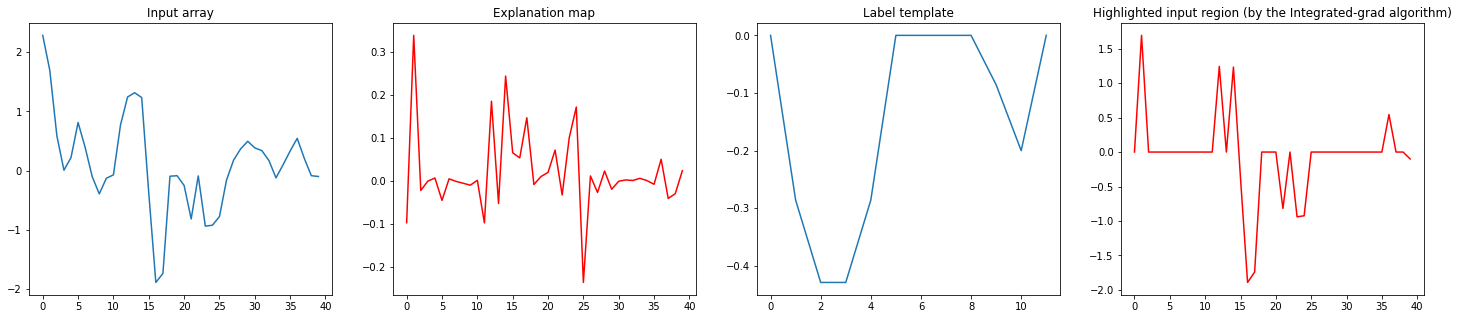

In [35]:
for i in range(10):
  index=True_list_labels.index(i)
  index=True_list[index]
  input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
  label = y_test[index]
  # print("input")
  #print('Correct digit: '+str(label))
  print('Correctly Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
  print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
  print()
  explanation = Integrated_gradient(input.flatten(),model, label)
  threshold = np.sort(explanation)[-12]

  plt.figure(figsize=(25,5))

  plt.subplot(1,4,1)
  plt.plot(input[0])
  plt.title('Input array')

  plt.subplot(1,4,2)
  plt.plot(explanation, 'r')
  plt.title('Explanation map')

  plt.subplot(1,4,3)
  plt.plot(dataset['templates']['x'][label])
  plt.title('Label template')

  plt.subplot(1,4,4)
  plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
  plt.title('Highlighted input region (by the Integrated-grad algorithm)')
plt.savefig('/content/drive/My Drive/torchray_master/correct_intgrad_MNIST1D.png')

## **For some wrong predictions:**

wrong prediction
Correct digit: 0
Predicted digit: 7
Confidence score for the correct label: 0.45365363

wrong prediction
Correct digit: 1
Predicted digit: 4
Confidence score for the correct label: 0.24164952

wrong prediction
Correct digit: 2
Predicted digit: 7
Confidence score for the correct label: 0.17883982

wrong prediction
Correct digit: 3
Predicted digit: 7
Confidence score for the correct label: 0.3431074

wrong prediction
Correct digit: 4
Predicted digit: 9
Confidence score for the correct label: 0.1019726

wrong prediction
Correct digit: 5
Predicted digit: 2
Confidence score for the correct label: 0.30337694

wrong prediction
Correct digit: 6
Predicted digit: 1
Confidence score for the correct label: 0.03538563

wrong prediction
Correct digit: 7
Predicted digit: 1
Confidence score for the correct label: 0.0030102963

wrong prediction
Correct digit: 8
Predicted digit: 5
Confidence score for the correct label: 0.03396985

wrong prediction
Correct digit: 9
Predicted digit: 4
Co

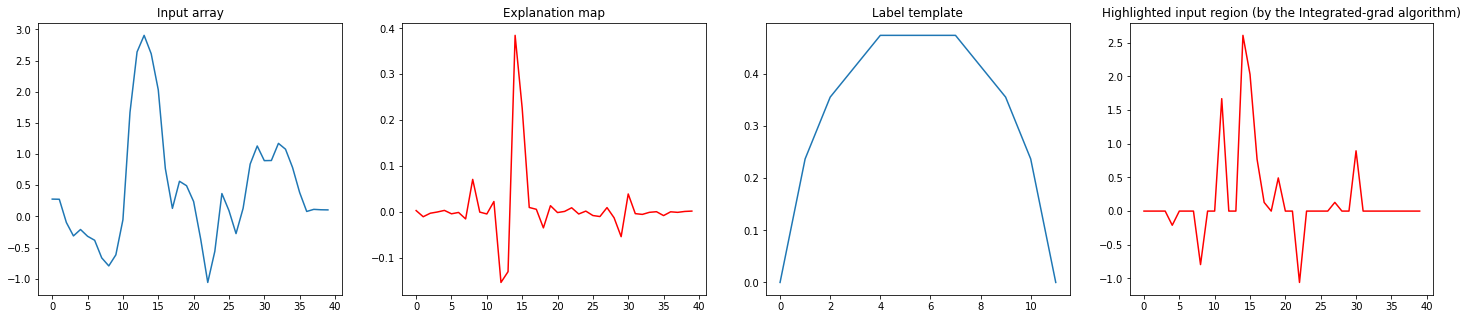

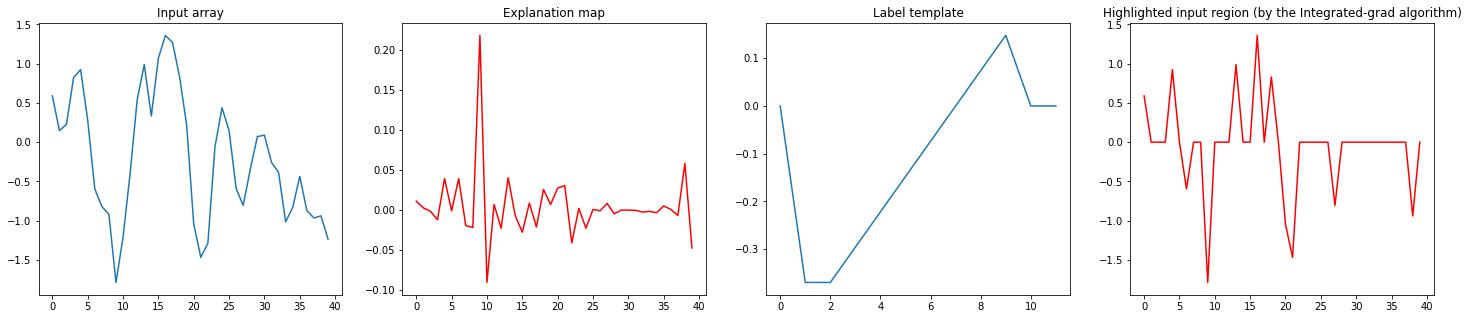

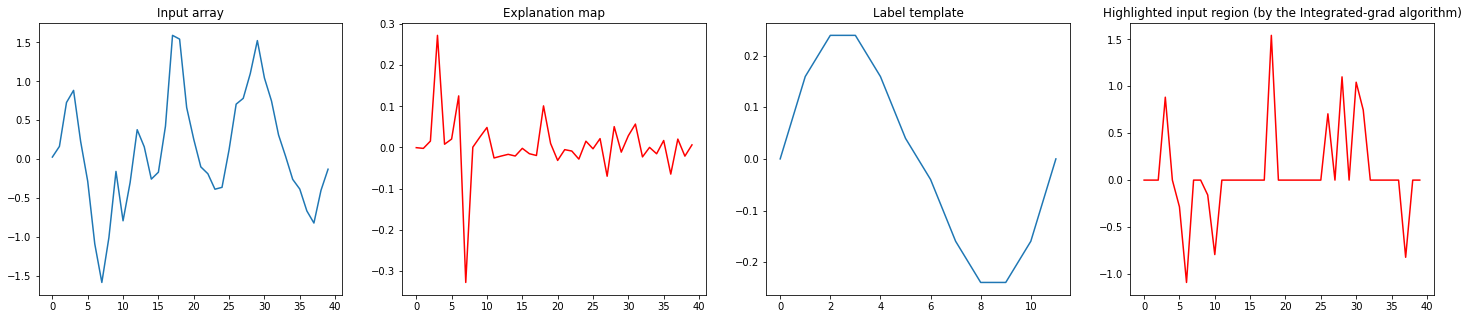

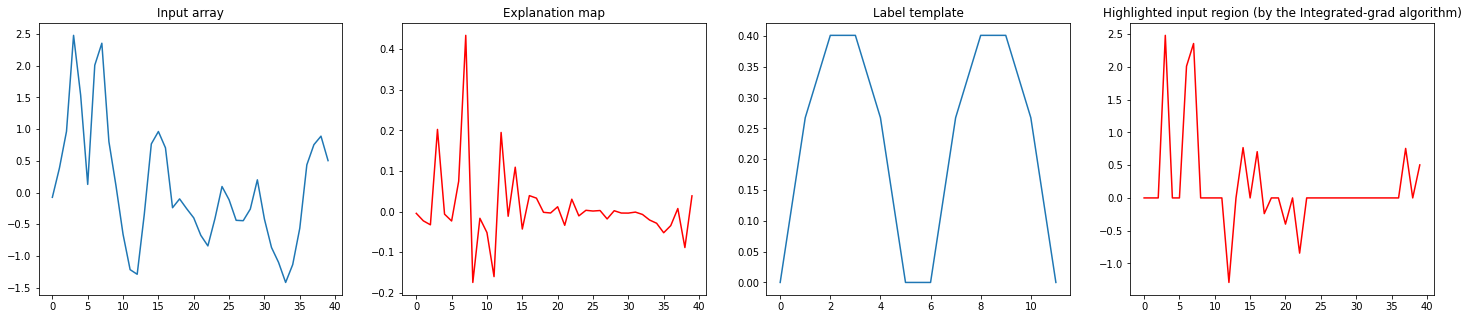

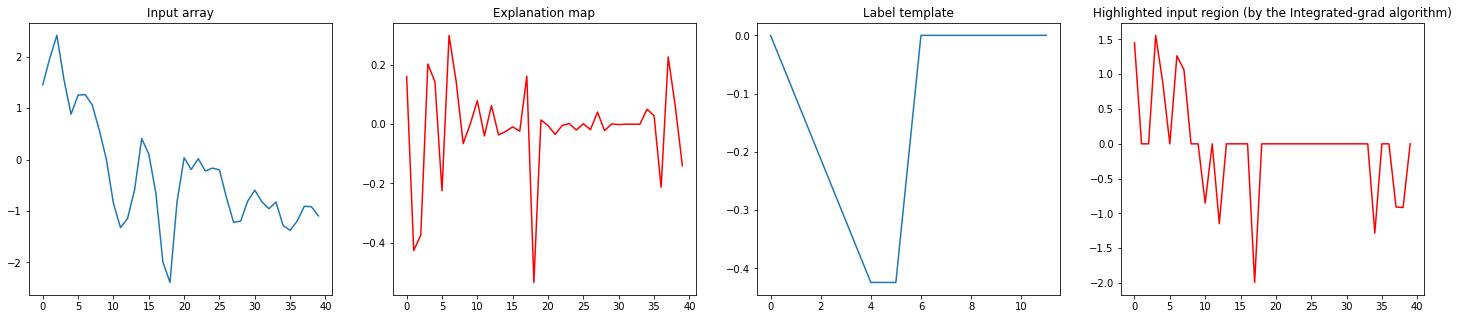

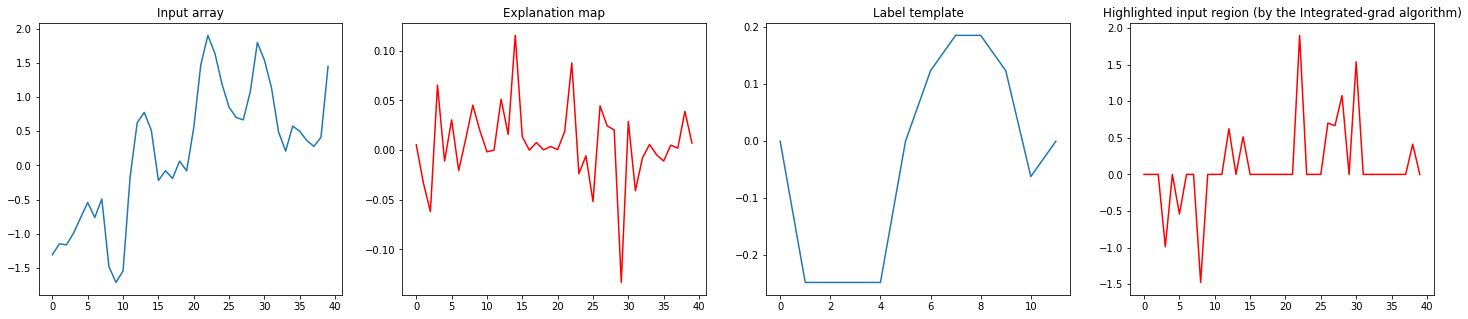

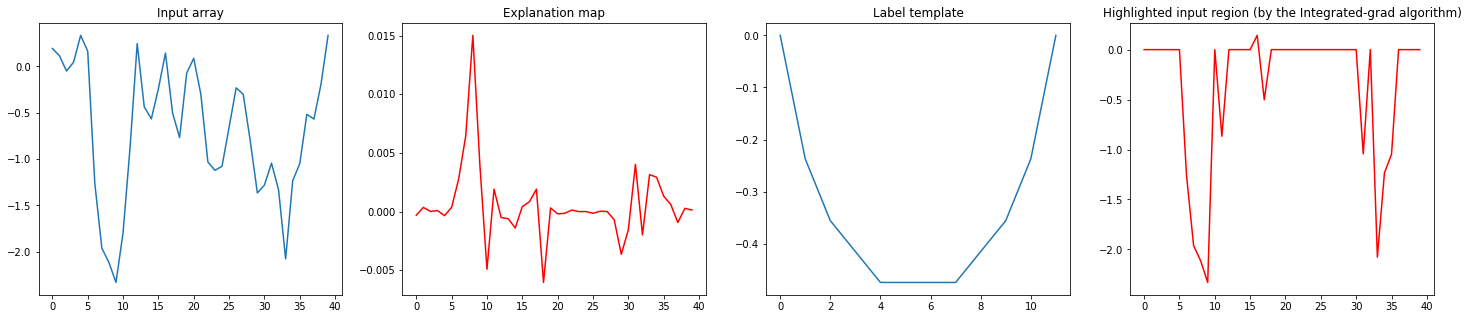

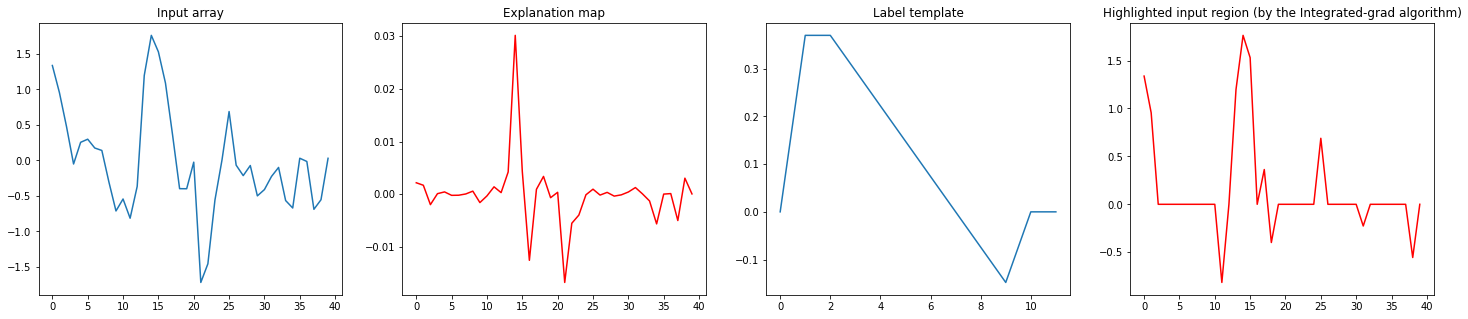

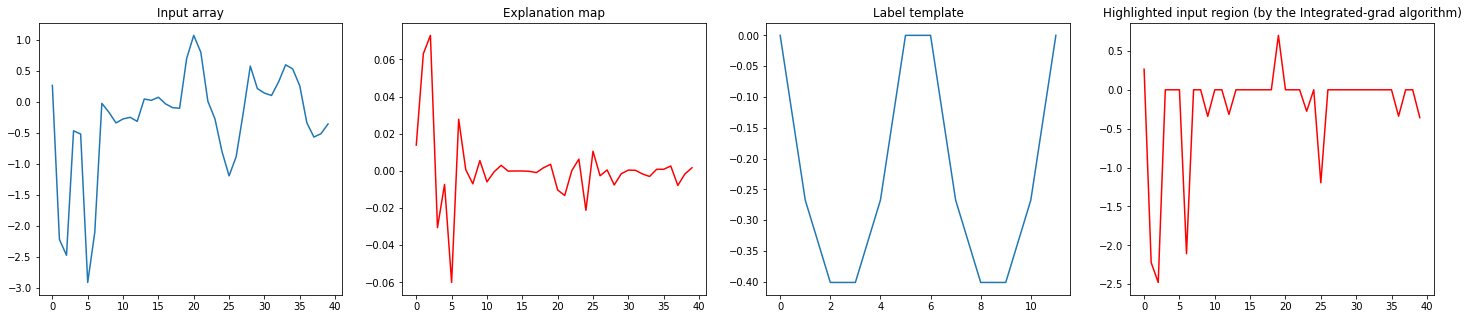

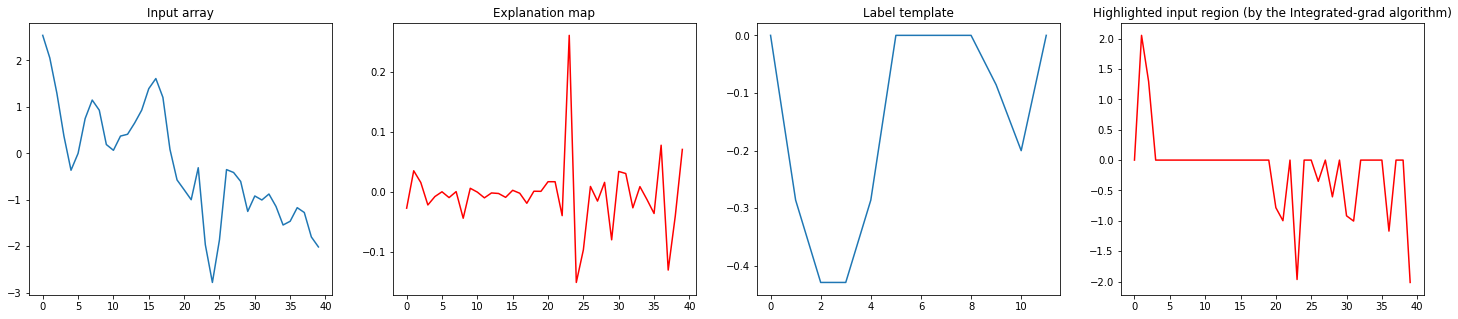

In [36]:
for i in range(10):
  if not i in Error_list_Truelabels:
    continue
  else:
    index=Error_list_Truelabels.index(i)
    index=Error_list[index]
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    print("wrong prediction")
    print('Correct digit: '+str(label))
    print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
    print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))
    print()
    explanation = Integrated_gradient(input.flatten(),model, label)
    threshold = np.sort(explanation)[-12]

    plt.figure(figsize=(25,5))

    plt.subplot(1,4,1)
    plt.plot(input[0])
    plt.title('Input array')

    plt.subplot(1,4,2)
    plt.plot(explanation, 'r')
    plt.title('Explanation map')

    plt.subplot(1,4,3)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')

    plt.subplot(1,4,4)
    plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
    plt.title('Highlighted input region (by the Integrated-grad algorithm)')
plt.savefig('/content/drive/My Drive/torchray_master/wrong_intgrad_MNIST1D.png')

## Quantitative evaluation

In [44]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr=img*exmap1_msk
    #exmap1_thr[0,:,0]=img[0,:,0]*exmap1_msk
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

In [47]:
drop_rate = 0.
increase_rate=0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = SISE(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, layers=[['conv1d_2']], class_index=np.argmax(prediction[0]), grad_thr=0.)
    d,i,_,_= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[0]), frac=0.3)
    drop_rate +=d
    increase_rate +=i
drop_rate /= 1000
increase_rate /= 1000
print("For SISE, we have a drop rate of "+ str(drop_rate)+" and a increase rate of "+ str(increase_rate))

For SISE, we have a drop rate of 0.34275615475599513 and a increase rate of 0.286


In [181]:
drop_rate = 0.
increase_rate=0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map = Integrated_gradient(np.expand_dims(x_test[index], axis=-1), model, label=np.argmax(prediction[index]))
    d,i,_,_= calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map, class_index=np.argmax(prediction[index]), frac=0.3)
    drop_rate +=d
    increase_rate +=i
drop_rate /= 1000
increase_rate /= 1000
print("For integrated gradient, we have a drop rate of "+ str(drop_rate)+" and a increase rate of "+ str(increase_rate))


For integrated gradient, we have a drop rate of 0.3483244354622285 and a increase rate of 0.324
